# Baseline Model - tree-based sklearn and xgboost models

Dependencies:
```
- numpy
- pandas
- matplotlib
- seaborn
- sklearn
- xgboost
- scipy (for joblib)
```

A big warning ahead: Most of the work here was done on the now obsolete full original baseline dataset and results may vary from run to run because this was before it was realized that random states were better fixed.

### Importing libraries and reading files

In [1]:
# Import statements
# sklearn stuff are imported later
import numpy as np
import pandas as pd
import xgboost as xgb
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Set path (optional)
'''dataset_dir = '../Dataset'
sys.path.append(dataset_dir)'''
!pwd

/userhome/cs/u3556490/efyp/Baseline


In [3]:
# read Dataset as Pandas DataFrame
print("================ Reading dataset, null check ===============")
dataset = pd.read_pickle('../Dataset/baseline_dataset.gz')
pd.set_option("display.max.columns", None)
print(dataset.info())

================ Reading dataset, null check ===============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45293 entries, 0 to 45292
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MM             45293 non-null  int64  
 1   DD             45293 non-null  int64  
 2   HH             45293 non-null  int64  
 3   LOW_IMPACT     45293 non-null  bool   
 4   MID_IMPACT     45293 non-null  bool   
 5   BIG_IMPACT     45293 non-null  bool   
 6   DIRECT_STRIKE  45293 non-null  bool   
 7   00LAT          45293 non-null  float32
 8   00LON          45293 non-null  float32
 9   00WIND         45293 non-null  int32  
 10  06LAT          45293 non-null  float32
 11  06LON          45293 non-null  float32
 12  06WIND         45293 non-null  int32  
 13  12LAT          45293 non-null  float32
 14  12LON          45293 non-null  float32
 15  12WIND         45293 non-null  int32  
 16  18LAT          45293 non-null  fl

In [4]:
# san-check: any nulls?
print("Null checking:")
print(dataset[dataset.isnull().any(axis=1)])

Null checking:
Empty DataFrame
Columns: [MM, DD, HH, LOW_IMPACT, MID_IMPACT, BIG_IMPACT, DIRECT_STRIKE, 00LAT, 00LON, 00WIND, 06LAT, 06LON, 06WIND, 12LAT, 12LON, 12WIND, 18LAT, 18LON, 18WIND, 24LAT, 24LON, 24WIND]
Index: []


In [5]:
dataset.describe()

,MM,DD,HH,00LAT,00LON,00WIND,06LAT,06LON,06WIND,12LAT,12LON,12WIND,18LAT,18LON,18WIND,24LAT,24LON,24WIND
count,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000
mean,8.283068,16.061025,8.918111,20.017653,132.009323,62.021063,19.506798,132.481476,62.087077,19.018631,132.967087,61.773122,18.551769,133.451675,61.072020,18.104473,133.910690,60.020864
std,2.310187,8.633509,6.698948,7.507561,19.457451,31.469743,7.243189,18.568924,31.423058,7.016464,17.948254,31.615497,6.824604,17.685791,31.978523,6.662520,17.910883,32.433757
min,1.000000,1.000000,0.000000,1.300000,-179.899994,10.000000,1.300000,-179.899994,10.000000,1.300000,-179.899994,10.000000,1.300000,-179.899994,10.000000,1.300000,-180.000000,10.000000
25%,7.000000,9.000000,0.000000,14.500000,121.800003,35.000000,14.200000,122.400002,35.000000,13.900000,123.000000,35.000000,13.600000,123.500000,35.000000,13.200000,124.000000,35.000000
50%,8.000000,16.000000,6.000000,19.200001,131.300003,55.000000,18.799999,131.600006,55.000000,18.400000,132.000000,55.000000,18.000000,132.399994,55.000000,17.600000,132.800003,55.000000
75%,10.000000,23.000000,12.000000,24.700001,142.399994,80.000000,24.100000,142.699997,80.000000,23.500000,143.000000,80.000000,22.900000,143.399994,80.000000,22.299999,143.899994,80.000000
max,12.000000,31.000000,23.000000,55.500000,180.000000,185.000000,54.500000,180.000000,185.000000,53.500000,180.000000,185.000000,52.000000,180.000000,185.000000,50.500000,180.000000,185.000000


### Dataset prepration tasks

In [6]:
# imports
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, classification_report, brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn import tree, ensemble, neural_network
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from matplotlib.gridspec import GridSpec

# Constants
TRAIN_RATIO = 0.9

In [7]:
# test-dev-train split

def separateDataset(dataset, train_ratio):
    '''
    Takes in a dataset (pandas df) and a ratio value, returns a dictionary containing the separated dataset.
    Key "train" = train set, "dev" = dev set (size = train ratio * (sizeof input df - test set)), "test" = test set (size = train ratio * sizeof input df)
    '''
    train_dev_set, test_set = train_test_split(dataset, train_size=train_ratio, random_state=42)
    train_set, dev_set = train_test_split(train_dev_set, train_size=train_ratio, random_state=42)
    print("Training set size: {0}; Dev set size: {1}; Testing set size: {2}".format(len(train_set), len(dev_set), len(test_set)))
    return { "train": train_set, "dev": dev_set, "test": test_set }

In [8]:
print("================ Preparing Datasets ===============")

def pandasToXY(dataframe):
    '''
    converts the given pandas df to X and Y sub-arrays. X is pandas df, Y is np int array.
    note: the range of columns to select as Y must be double checked when a different dataset is used.
    '''
    X = dataframe.drop(['LOW_IMPACT', 'MID_IMPACT', 'BIG_IMPACT', 'DIRECT_STRIKE'], axis=1)
    Y = np.asarray(dataframe.iloc[:,3:7]).astype(int)
    return X, Y

# train-dev-test splitting
splitDataset = separateDataset(dataset, TRAIN_RATIO)
# separate each of the 3 sets into X and Y
train_full = splitDataset["train"]
train_X, train_Y = pandasToXY(train_full)
dev_full = splitDataset["dev"]
dev_X, dev_Y = pandasToXY(dev_full)
test_full = splitDataset["test"]
test_X, test_Y = pandasToXY(test_full)

================ Preparing Datasets ===============
Training set size: 36686; Dev set size: 4077; Testing set size: 4530


### Testing utilities 
The following uses the deterministic outputs instead of probabilities/confidence scores unless specified. 

In [9]:
# test whether sensible probabilities are returned
def test_obtaining_probabilities(tc_clf, dataset_X, dataset_Y):
    '''
    Takes in a classifier, an input set X and a target set Y; tries to obtain and show class probability values from the classifier
    using random samples in X and displays the corresponding Y.
    '''
    from random import randrange
    for i in range(5):
        idx = randrange(len(dataset_X))
        print("Testing data item {0}, probabilities: ".format(idx))
        print(tc_clf.predict_proba((dataset_X.iloc[idx]).to_numpy().reshape(1,-1)))
        print("Ground truth: ", dataset_Y[idx]) # this one is np array

In [10]:
# accuracy testing II: F1 scores
# performs comparison between model and dummy F1 scores
def test_F1_scores(tc_clf, thresholds, dataset_X, dataset_Y):
    '''
    Takes in a classifier, a set of decision thresholds, input set X and targets set Y;
    Displays the F1 scores (classes separate) of the classifier and compares them to dummies.
    '''
    target = dataset_Y
    preds = predictions_with_thresholds(tc_clf, thresholds, dataset_X) # preds = tc_clf.predict(dataset_X)
    model_f1 = f1_score(target, preds, average=None, zero_division=0)
    print("model's F1 score is: ", model_f1)

    dummy_preds = np.array([[1, 1, 1, 1] for i in range(len(dataset_X))])
    dummy_f1 = f1_score(target, dummy_preds, average=None, zero_division=0)
    print("dummy (always say Yes) F1 score is: ", dummy_f1)
    
    dummy_preds = np.array([[0, 0, 0, 0] for i in range(len(dataset_X))])
    dummy_f1 = f1_score(target, dummy_preds, average=None, zero_division=0)
    print("dummy (always say No) F1 score is: ", dummy_f1)

In [11]:
# make calibration plots for class (label) 0 and 3
def calibration_plot(clf, dataset_X, dataset_Y):
    '''
    Takes in a classifier, an input set X and a target set Y;
    Calculates and shows Brier scores and plots calibration graphs for reference.
    '''
    # brier score loss
    print("Brier score losses: (the smaller the better)")    
    all_preds = np.array(clf.predict_proba(dataset_X))
    for i in range(4):
        if isinstance(clf, OneVsRestClassifier) or isinstance(clf, ClassifierChain):
            preds = all_preds[:,i]
        else:
            preds = all_preds[i,:,1]
        clf_score = brier_score_loss(dataset_Y[:,i], preds)
        print("Class {0}, no calibration: {1:1.6f}".format(i, clf_score))

    # plot calibration graphs
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    ax = fig.add_subplot(gs[:2, :2])

    preds = np.array(clf.predict_proba(dataset_X))
    preds = preds[:,0] if isinstance(clf, OneVsRestClassifier) or isinstance(clf, ClassifierChain) else preds[0,:,1]
    display = CalibrationDisplay.from_predictions(dataset_Y[:,0], preds, n_bins=10, name="class 0", ax=ax, strategy='uniform')
    preds = np.array(clf.predict_proba(dataset_X))
    preds = preds[:,3] if isinstance(clf, OneVsRestClassifier) or isinstance(clf, ClassifierChain) else preds[3,:,1]
    display = CalibrationDisplay.from_predictions(dataset_Y[:,3], preds, n_bins=10, name="class 3", ax=ax, strategy='uniform')

    ax.grid()
    plt.tight_layout()
    plt.show()

In [12]:
# optimize thresholds; also two versions
def optimize_thresholds(clf, dataset_X, dataset_Y):
    '''
    Takes in a classifier, an input set X and a target set Y; returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    # find the best decision thresholds and the corresponding F1 scores
    all_preds = np.array(clf.predict_proba(dataset_X))
    best_thresholds = []
    best_f1_scores = []
    n_classes = len(clf.classes_)
    for i in range(n_classes):
        if isinstance(clf, OneVsRestClassifier) or isinstance(clf, ClassifierChain):
            precision, recall, thresholds = precision_recall_curve(dataset_Y[:,i], all_preds[:,i])
        else:
            precision, recall, thresholds = precision_recall_curve(dataset_Y[:,i], all_preds[i,:,1])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

    # plot the precision-recall curve for the last class/label
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
    
    return best_thresholds, best_f1_scores

In [13]:
def predictions_with_thresholds(clf, thresholds, dataset_X):
    '''
    Takes in a classifier, a list of decision thresholds and an input samples set X;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = np.array(clf.predict_proba(dataset_X))
    n_classes = len(clf.classes_)
    preds = []
    # iterate each predicted probability and compare against threshold
    if isinstance(clf, OneVsRestClassifier) or isinstance(clf, ClassifierChain):
        for i in range(preds_probs.shape[0]):
            pred_row = []
            for j in range(n_classes):
                if preds_probs[i,j] > thresholds[j]:
                    pred_row.append(1)
                else:
                    pred_row.append(0)
            preds.append(pred_row)
    else:
        for i in range(preds_probs.shape[1]):
            pred_row = []
            for j in range(n_classes):
                if preds_probs[j,i,1] > thresholds[j]:
                    pred_row.append(1)
                else:
                    pred_row.append(0)
            preds.append(pred_row)
    
    return np.array(preds)

In [14]:
# accuracies by class
def test_acc_by_class(tc_clf, thresholds, dataset_X, dataset_Y): 
    '''
    Takes in a classifier, a list of decision thresholds, an input samples set X and a targets set Y;
    returns lists of accuracies per class/target
    '''
    
    low_impact_acc = 0
    mid_impact_acc = 0
    big_impact_acc = 0
    direct_strike_acc = 0
    
    preds = predictions_with_thresholds(tc_clf, thresholds, dataset_X)    
    # preds = tc_clf.predict(dataset_X)
    
    for i in range(4):
        print("[Class based general acc] now testing: ",end='')
        if i == 0:
            print("LOW_IMPACT")
        elif i == 1:
            print("MID_IMPACT")
        elif i == 2:
            print("BIG_IMPACT")
        elif i == 3:
            print("DIRECT_STRIKE")

        model_f1 = f1_score(dataset_Y, preds, average=None, zero_division=0)
        print("model's F1 score is: ", model_f1)
        acc = accuracy_score(dataset_Y[:,i], preds[:,i])
        print("model's accuracy is: ", acc)
        
        if i == 0:
            low_impact_acc = acc
        elif i == 1:
            mid_impact_acc = acc
        elif i == 2:
            big_impact_acc = acc
        elif i == 3:
            direct_strike_acc = acc
        
    return low_impact_acc, mid_impact_acc, big_impact_acc, direct_strike_acc

In [15]:
# Dummy baselines
def get_dummy_accuracies(dataset_X, dataset_Y):
    '''
    Takes in a samples set X and a target set Y; returns:
    - overall accuracies for all-positive and all-negative predictions
    - target-by-target accuracies for all-positive and all-negative predictions
    - recalls for all-positive and all-negative predictions
    '''
    # general predictions
    # always yes predictions
    dummy_yes_preds = np.array([[1, 1, 1, 1] for i in range(len(dataset_X))])
    yes_acc = accuracy_score(dataset_Y, dummy_yes_preds)
    
    # always no predictions
    dummy_no_preds = np.array([[0, 0, 0, 0] for i in range(len(dataset_X))])
    no_acc = accuracy_score(dataset_Y, dummy_no_preds)
    
    # class by class
    yes_class_acc = []
    for i in range(4):
        yes_class_acc.append(accuracy_score(dataset_Y[:,i], dummy_yes_preds[:,i]))
    no_class_acc = []
    for i in range(4):
        no_class_acc.append(accuracy_score(dataset_Y[:,i], dummy_no_preds[:,i]))
        
    # given true positives
    yes_class_tp_acc = []
    no_class_tp_acc = []
    for i in range(4):
        if i == 0: hoisted_set = dataset.query("LOW_IMPACT == True") # uses whole dataset
        elif i == 1: hoisted_set = dataset.query("MID_IMPACT == True")
        elif i == 2: hoisted_set = dataset.query("BIG_IMPACT == True")
        elif i == 3: hoisted_set = dataset.query("DIRECT_STRIKE == True")

        _, hoisted_Y = pandasToXY(hoisted_set)
        dummy_yes_preds = np.array([[1, 1, 1, 1] for i in range(len(hoisted_set))])
        dummy_no_preds = np.array([[0, 0, 0, 0] for i in range(len(hoisted_set))])
        yes_class_tp_acc.append(accuracy_score(hoisted_Y[:,i], dummy_yes_preds[:,i]))
        no_class_tp_acc.append(accuracy_score(hoisted_Y[:,i], dummy_no_preds[:,i]))
    
    return yes_acc, no_acc, yes_class_acc, no_class_acc, yes_class_tp_acc, no_class_tp_acc

In [16]:
## Bookkeeping

# overall acc
base_accuracies = dict() 
# general class-based accuracies
low_impact_accuracies = dict()
mid_impact_accuracies = dict()
big_impact_accuracies = dict()
direct_strike_accuracies = dict()
# true positives given positive (recall)
low_impact_recall = dict()
mid_impact_recall = dict()
big_impact_recall = dict()
direct_strike_recall = dict()
# true positives among selected (precision)
low_impact_precision = dict()
mid_impact_precision = dict()
big_impact_precision = dict()
direct_strike_precision = dict()

# record best F1 scores for comparison
low_impact_f1 = dict()
mid_impact_f1 = dict()
big_impact_f1 = dict()
direct_strike_f1 = dict()
# thresholds corresponding to the best F1 scores
low_impact_threshold = dict()
mid_impact_threshold = dict()
big_impact_threshold = dict()
direct_strike_threshold = dict()

In [17]:
ALWAYS_YES_ACC, ALWAYS_NO_ACC, ALWAYS_YES_CLASS_ACC, ALWAYS_NO_CLASS_ACC, ALWAYS_YES_CLASS_TP_ACC, ALWAYS_NO_CLASS_TP_ACC = get_dummy_accuracies(dev_X, dev_Y)
print(get_dummy_accuracies(train_X, train_Y))
print(get_dummy_accuracies(dev_X, dev_Y))

(0.007059913863599193, 0.8854331352559559, [0.08883497792073271, 0.06860927874393502, 0.026331570626396992, 0.018753748023769286], [0.9111650220792673, 0.931390721256065, 0.973668429373603, 0.9812462519762307], [1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0])
(0.006867794947265146, 0.8861908265881776, [0.09173411822418445, 0.06524405199901889, 0.02256561196958548, 0.01741476575913662], [0.9082658817758156, 0.9347559480009812, 0.9774343880304145, 0.9825852342408634], [1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0])


In [18]:
import joblib
from datetime import datetime

def save_sklearn_model_to_file(model, model_type, filename=None):
    '''Saves a sklearn model to file. Takes in the model, a name for the model and optionally a full filename.'''
    if filename == None:
        filename = "./models/baseline_model_{0}_{1}.skl".format(model_type, str(datetime.now().strftime("%Y-%m-%d %H-%M")))
        
    joblib.dump(model, filename)
    
    # to load a model: model = joblib.load(filename)
    
# for XGBoost, unused
def save_xgboost_model_to_file(model, model_type, filename=None):
    '''Saves an XGBoost model to file, unused'''
    if filename == None:
        filename = "./models/baseline_model_{0}_{1}.json".format(model_type, str(datetime.now().strftime("%Y-%m-%d %H-%M")))
        
    model.save_model(filename)
    
    # to load a model: model.load_model(filename)

For any forecasting model to have skill, it must outperform a naive (always "No" or "Yes") forecaster. The general requirements are:

- training accuracy: at least 88.4574%
- validation accuracy: 88.4805%
- F1 scores: N/A
- DS true positive accuracy (recall): N/A
- DS precision: N/A
- DS general accuracy: 97.9610%

### Forecasting model tried

#### Single decision tree classifier

max_depth = 15 => 88.78% dev acc, F1 \[0.60310078 0.55938697 0.48484848 0.44186047\], 39.31% DS true positive acc, 97.8311% DS general acc; **optimized**: Thresholds \[0.46667 0.38889 0.45000 0.61538\], F1 \[0.65027 0.62541 0.52217 0.47059\]

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.058245
Class 1, no calibration: 0.044982
Class 2, no calibration: 0.025795
Class 3, no calibration: 0.021279


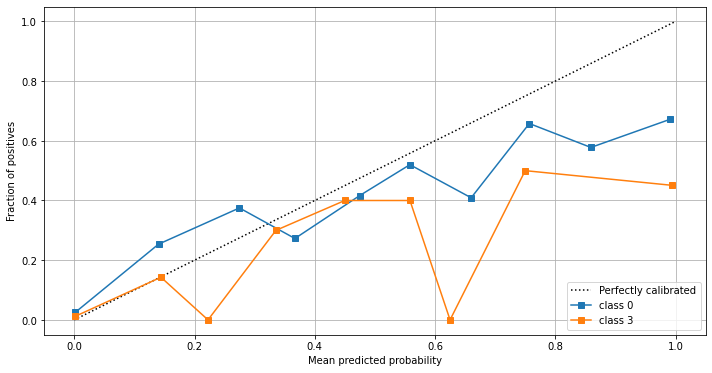

In [17]:
# fit model
single_dt_tc_clf = tree.DecisionTreeClassifier(max_depth=15)
single_dt_tc_clf.fit(train_X, train_Y)

calibration_plot(single_dt_tc_clf, dev_X, dev_Y)

Testing data item 345, probabilities: 
[array([[0.06976744, 0.93023256]]), array([[0.86046512, 0.13953488]]), array([[1., 0.]]), array([[0.97674419, 0.02325581]])]
Ground truth:  [1 0 0 0]
Testing data item 3294, probabilities: 
[array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]])]
Ground truth:  [0 0 0 0]
Testing data item 399, probabilities: 
[array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]])]
Ground truth:  [0 0 0 0]
Testing data item 1280, probabilities: 
[array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]])]
Ground truth:  [0 0 0 0]
Testing data item 176, probabilities: 
[array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]])]
Ground truth:  [0 0 0 0]
Best Threshold=0.18182, F-Score=0.65398
Best Threshold=0.27273, F-Score=0.63680
Best Threshold=0.21875, F-Score=0.54417
Best Threshold=0.31818, F-Score=0.38994


/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with featur

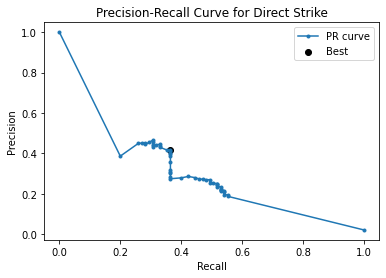

In [18]:
# preliminary testing: can obtain probabilities?
test_obtaining_probabilities(single_dt_tc_clf, dev_X, dev_Y)

# find the best decision thresholds and the corresponding F1 scores
best_thresholds, best_f1_scores = optimize_thresholds(single_dt_tc_clf, dev_X, dev_Y)

# bookkeeping
low_impact_threshold["single_decision_tree"] = best_thresholds[0]
mid_impact_threshold["single_decision_tree"] = best_thresholds[1]
big_impact_threshold["single_decision_tree"] = best_thresholds[2]
direct_strike_threshold["single_decision_tree"] = best_thresholds[3]
low_impact_f1["single_decision_tree"] = best_f1_scores[0]
mid_impact_f1["single_decision_tree"] = best_f1_scores[1]
big_impact_f1["single_decision_tree"] = best_f1_scores[2]
direct_strike_f1["single_decision_tree"] = best_f1_scores[3]

In [19]:
# train set behaviour
preds = predictions_with_thresholds(single_dt_tc_clf, best_thresholds, train_X)
print("Accuracy on training data: {0:.10f}".format(accuracy_score(train_Y, preds)))

# test model on dev set
preds = predictions_with_thresholds(single_dt_tc_clf, best_thresholds, dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))
base_accuracies["single_decision_tree"] = acc
# classification report
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

Accuracy on training data: 0.9521615875
Accuracy of classifier on dev set: 0.8830022075
              precision    recall  f1-score   support

           0    0.59560   0.72074   0.65223       376
           1    0.60802   0.65886   0.63242       299
           2    0.50331   0.58462   0.54093       130
           3    0.41667   0.35294   0.38217        85

   micro avg    0.57285   0.64494   0.60677       890
   macro avg    0.53090   0.57929   0.55194       890
weighted avg    0.56921   0.64494   0.60352       890
 samples avg    0.07358   0.07479   0.07073       890



In [23]:
# F1 score comparison (to dummies)
test_F1_scores(single_dt_tc_clf, best_thresholds, dev_X, dev_Y)

# compute recall, precision and class-based accuracy scores
# low_impact_acc, mid_impact_acc, big_impact_acc, direct_strike_acc = test_usefulness(tc_clf, "dev")
preds = predictions_with_thresholds(single_dt_tc_clf, best_thresholds, dev_X)
recall = recall_score(dev_Y, preds, average=None, zero_division=0)
print("Recall score: ", recall)
low_impact_recall["single_decision_tree"] = recall[0]
mid_impact_recall["single_decision_tree"] = recall[1]
big_impact_recall["single_decision_tree"] = recall[2]
direct_strike_recall["single_decision_tree"] = recall[3]

precision = precision_score(dev_Y, preds, average=None, zero_division=0)
print("Precision score: ", precision)
low_impact_precision["single_decision_tree"] = precision[0]
mid_impact_precision["single_decision_tree"] = precision[1]
big_impact_precision["single_decision_tree"] = precision[2]
direct_strike_precision["single_decision_tree"] = precision[3]

low_impact_acc, mid_impact_acc, big_impact_acc, direct_strike_acc = test_acc_by_class(single_dt_tc_clf, best_thresholds, dev_X, dev_Y)
low_impact_accuracies["single_decision_tree"] = low_impact_acc
mid_impact_accuracies["single_decision_tree"] = mid_impact_acc
big_impact_accuracies["single_decision_tree"] = big_impact_acc
direct_strike_accuracies["single_decision_tree"] = direct_strike_acc

model's F1 score is:  [0.65222623 0.63242376 0.54092527 0.38216561]
dummy (always say Yes) F1 score is:  [0.16887492 0.13665448 0.06180176 0.04084575]
dummy (always say No) F1 score is:  [0. 0. 0. 0.]
Recall score:  [0.72074468 0.65886288 0.58461538 0.35294118]
Precision score:  [0.5956044  0.60802469 0.50331126 0.41666667]
[Class based general acc] now testing: LOW_IMPACT
model's F1 score is:  [0.65222623 0.63242376 0.54092527 0.38216561]
model's accuracy is:  0.9291145450085847
[Class based general acc] now testing: MID_IMPACT
model's F1 score is:  [0.65222623 0.63242376 0.54092527 0.38216561]
model's accuracy is:  0.94383124846701
[Class based general acc] now testing: BIG_IMPACT
model's F1 score is:  [0.65222623 0.63242376 0.54092527 0.38216561]
model's accuracy is:  0.9683590875643856
[Class based general acc] now testing: DIRECT_STRIKE
model's F1 score is:  [0.65222623 0.63242376 0.54092527 0.38216561]
model's accuracy is:  0.9762079960755458


In [ ]:
# visualization, not very useful
print(single_dt_tc_clf.export_text(tc_clf, feature_names=[
    "MM", "DD", "HH", "00LAT", "00LON", "00WIND",
    "06LAT", "06LON", "06WIND","12LAT", "12LON", "12WIND",
    "18LAT", "18LON", "18WIND","24LAT", "24LON", "24WIND"
]))

In [ ]:
# save model
save_sklearn_model_to_file(single_dt_tc_clf, "single_decision_tree")

#### Ensemble: Extra Trees Classifier

(n_estimators=400, max_depth=20) => 91.14% dev acc, F1 \[0.64655985 0.5734767  0.30508475 0.04054054\], 2.07% DS true positive acc, 98.0390% DS general acc; **optimized**: Best thresholds \[0.37979 0.29994 0.24555 0.19402\], F-Score \[0.74504 0.71562 0.70320 0.68831\]

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.039242
Class 1, no calibration: 0.030037
Class 2, no calibration: 0.012777
Class 3, no calibration: 0.011097


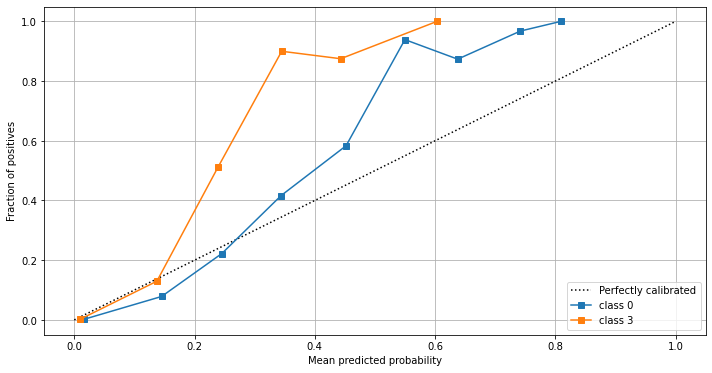

In [19]:
# fit new model
extra_trees_tc_clf = ensemble.ExtraTreesClassifier(random_state=42, n_estimators=400, max_depth=20, n_jobs=-1, verbose=0)
extra_trees_tc_clf.fit(train_X, train_Y)

calibration_plot(extra_trees_tc_clf, dev_X, dev_Y)

Testing data item 3948, probabilities: 


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


[array([[9.99889831e-01, 1.10169492e-04]]), array([[9.99966102e-01, 3.38983051e-05]]), array([[1., 0.]]), array([[1., 0.]])]
Ground truth:  [0 0 0 0]
Testing data item 1188, probabilities: 
[array([[0.9888677, 0.0111323]]), array([[9.99146806e-01, 8.53193844e-04]]), array([[9.99952396e-01, 4.76041480e-05]]), array([[9.99973404e-01, 2.65957447e-05]])]
Ground truth:  [0 0 0 0]
Testing data item 676, probabilities: 


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


[array([[0.97459835, 0.02540165]]), array([[0.97659309, 0.02340691]]), array([[0.99581935, 0.00418065]]), array([[0.99647171, 0.00352829]])]
Ground truth:  [0 0 0 0]
Testing data item 2980, probabilities: 
[array([[0.69616285, 0.30383715]]), array([[0.88058347, 0.11941653]]), array([[0.95575767, 0.04424233]]), array([[0.62048232, 0.37951768]])]
Ground truth:  [0 0 0 1]
Testing data item 2783, probabilities: 


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


[array([[9.99482811e-01, 5.17188694e-04]]), array([[9.99710084e-01, 2.89915966e-04]]), array([[1., 0.]]), array([[1., 0.]])]
Ground truth:  [0 0 0 0]
Best Threshold=0.30762, F-Score=0.74271
Best Threshold=0.32100, F-Score=0.71429
Best Threshold=0.23209, F-Score=0.70000
Best Threshold=0.18134, F-Score=0.69677


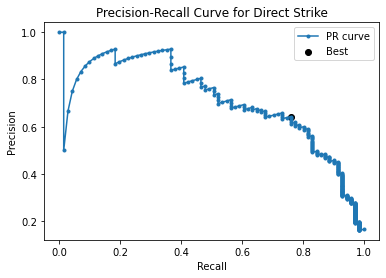

In [20]:
# preliminary testing: can obtain probabilities?
test_obtaining_probabilities(extra_trees_tc_clf, dev_X, dev_Y)

# find the best decision thresholds and the corresponding F1 scores
best_thresholds, best_f1_scores = optimize_thresholds(extra_trees_tc_clf, dev_X, dev_Y)

# bookkeeping
low_impact_threshold["extra_trees_400"] = best_thresholds[0]
mid_impact_threshold["extra_trees_400"] = best_thresholds[1]
big_impact_threshold["extra_trees_400"] = best_thresholds[2]
direct_strike_threshold["extra_trees_400"] = best_thresholds[3]
low_impact_f1["extra_trees_400"] = best_f1_scores[0]
mid_impact_f1["extra_trees_400"] = best_f1_scores[1]
big_impact_f1["extra_trees_400"] = best_f1_scores[2]
direct_strike_f1["extra_trees_400"] = best_f1_scores[3]

In [21]:
# train set behaviour
preds = predictions_with_thresholds(extra_trees_tc_clf, best_thresholds, train_X)
print("Accuracy on training data: {0:.10f}".format(accuracy_score(train_Y, preds)))

# test model on dev set
preds = predictions_with_thresholds(extra_trees_tc_clf, best_thresholds, dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))
base_accuracies["extra_trees_400"] = acc
# classification report
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

Accuracy on training data: 0.9913591016
Accuracy of classifier on dev set: 0.9139072848
              precision    recall  f1-score   support

           0    0.70531   0.78075   0.74112       374
           1    0.67918   0.74812   0.71199       266
           2    0.64486   0.75000   0.69347        92
           3    0.63855   0.74648   0.68831        71

   micro avg    0.68339   0.76339   0.72118       803
   macro avg    0.66698   0.75634   0.70872       803
weighted avg    0.68383   0.76339   0.72134       803
 samples avg    0.07798   0.08448   0.07803       803



In [22]:
# F1 score comparison (to dummies)
test_F1_scores(extra_trees_tc_clf, best_thresholds, dev_X, dev_Y)

# compute recall, precision and class-based accuracy scores
# low_impact_acc, mid_impact_acc, big_impact_acc, direct_strike_acc = test_usefulness(tc_clf, "dev")
preds = predictions_with_thresholds(extra_trees_tc_clf, best_thresholds, dev_X)
recall = recall_score(dev_Y, preds, average=None, zero_division=0)
print("Recall score: ", recall)
low_impact_recall["extra_trees_400"] = recall[0]
mid_impact_recall["extra_trees_400"] = recall[1]
big_impact_recall["extra_trees_400"] = recall[2]
direct_strike_recall["extra_trees_400"] = recall[3]

precision = precision_score(dev_Y, preds, average=None, zero_division=0)
print("Precision score: ", precision)
low_impact_precision["extra_trees_400"] = precision[0]
mid_impact_precision["extra_trees_400"] = precision[1]
big_impact_precision["extra_trees_400"] = precision[2]
direct_strike_precision["extra_trees_400"] = precision[3]

low_impact_acc, mid_impact_acc, big_impact_acc, direct_strike_acc = test_acc_by_class(extra_trees_tc_clf, best_thresholds, dev_X, dev_Y)
low_impact_accuracies["extra_trees_400"] = low_impact_acc
mid_impact_accuracies["extra_trees_400"] = mid_impact_acc
big_impact_accuracies["extra_trees_400"] = big_impact_acc
direct_strike_accuracies["extra_trees_400"] = direct_strike_acc

model's F1 score is:  [0.74111675 0.71198569 0.69346734 0.68831169]
dummy (always say Yes) F1 score is:  [0.16805212 0.12249597 0.04413528 0.03423337]
dummy (always say No) F1 score is:  [0. 0. 0. 0.]
Recall score:  [0.78074866 0.7481203  0.75       0.74647887]
Precision score:  [0.70531401 0.67918089 0.64485981 0.63855422]
[Class based general acc] now testing: LOW_IMPACT
model's F1 score is:  [0.74111675 0.71198569 0.69346734 0.68831169]
model's accuracy is:  0.9499632082413539
[Class based general acc] now testing: MID_IMPACT
model's F1 score is:  [0.74111675 0.71198569 0.69346734 0.68831169]
model's accuracy is:  0.9605101790532254
[Class based general acc] now testing: BIG_IMPACT
model's F1 score is:  [0.74111675 0.71198569 0.69346734 0.68831169]
model's accuracy is:  0.9850380181506009
[Class based general acc] now testing: DIRECT_STRIKE
model's F1 score is:  [0.74111675 0.71198569 0.69346734 0.68831169]
model's accuracy is:  0.9882266372332598


In [ ]:
# save model
save_sklearn_model_to_file(extra_trees_tc_clf, "extra_trees_400")

##### Regressor version

In [27]:
from sklearn.ensemble import ExtraTreesRegressor

regr = ExtraTreesRegressor(random_state=42, n_estimators=400, max_depth=20, n_jobs=4, verbose=0).fit(train_X, train_Y)

Best Threshold=0.37414, F-Score=0.78133
Best Threshold=0.35460, F-Score=0.77879
Best Threshold=0.30751, F-Score=0.75000
Best Threshold=0.24179, F-Score=0.74359


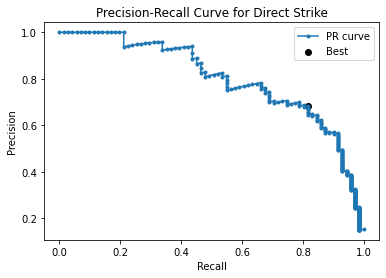

In [28]:
all_preds = np.clip(regr.predict(dev_X), 0, 1)

best_thresholds = []
best_f1_scores = []
for i in range(4):
    precision, recall, thresholds = precision_recall_curve(dev_Y[:,i], all_preds[:,i])
    # find best threshold
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.nanargmax(fscore)
    best_thresholds.append(thresholds[ix])
    best_f1_scores.append(fscore[ix])
    print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.', label='PR curve')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Direct Strike')
plt.legend()

In [29]:
preds = []
# iterate each predicted probability and compare against threshold
for i in range(len(all_preds)):
    pred_row = []
    for j in range(4):
        if all_preds[i,j] > best_thresholds[j]:
            pred_row.append(1)
        else:
            pred_row.append(0)
    preds.append(pred_row)

preds = np.array(preds)

print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.77867   0.78075   0.77971       374
           1    0.75714   0.79699   0.77656       266
           2    0.71717   0.77174   0.74346        92
           3    0.67857   0.80282   0.73548        71

   micro avg    0.75418   0.78705   0.77026       803
   macro avg    0.73289   0.78807   0.75880       803
weighted avg    0.75564   0.78705   0.77060       803
 samples avg    0.08145   0.08671   0.08153       803



Brier score losses: (the smaller the better)
Class 0, no calibration: 0.030772
Class 1, no calibration: 0.024127
Class 2, no calibration: 0.010180
Class 3, no calibration: 0.008533


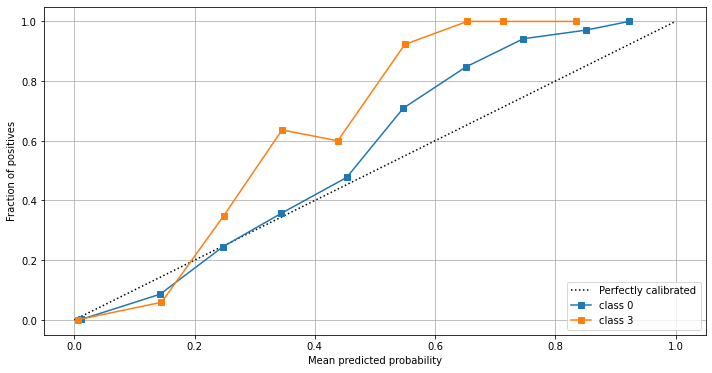

In [30]:
print("Brier score losses: (the smaller the better)")
for i in range(4):
    preds = all_preds[:,i]
    clf_score = brier_score_loss(dev_Y[:,i], preds)
    print("Class {0}, no calibration: {1:1.6f}".format(i, clf_score))

# plot calibration graphs
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
ax = fig.add_subplot(gs[:2, :2])

preds = all_preds
preds = preds[:,0]
display = CalibrationDisplay.from_predictions(dev_Y[:,0], preds, n_bins=10, name="class 0", ax=ax, strategy='uniform')
preds = all_preds
preds = preds[:,3]
display = CalibrationDisplay.from_predictions(dev_Y[:,3], preds, n_bins=10, name="class 3", ax=ax, strategy='uniform')

ax.grid()
plt.tight_layout()
plt.show()

#### Ensemble: Random Forest Classifier

(n_estimators=400, max_depth=20) => 91.42% dev acc, F1 \[0.6973572  0.64262295 0.4765343  0.34831461\], 21.38% DS true positive acc, 98.2208% DS general acc; **optimized**: Best thresholds = \[0.35455 0.31557 0.23633 0.21027\], F-Score = \[0.74005 0.69440 0.63813 0.59172 \]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    8.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s


Brier score losses: (the smaller the better)


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s


Class 0, no calibration: 0.034923
Class 1, no calibration: 0.028660
Class 2, no calibration: 0.015330
Class 3, no calibration: 0.012625


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.6s finished


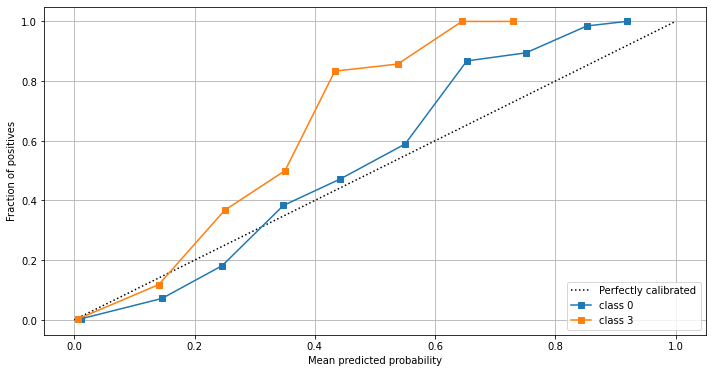

In [28]:
# fit new model
random_forest_tc_clf = ensemble.RandomForestClassifier(n_estimators=400, max_depth=20, verbose=1, n_jobs=4)
random_forest_tc_clf.fit(train_X, train_Y)

calibration_plot(random_forest_tc_clf, dev_X, dev_Y)

Testing data item 2296, probabilities: 
[array([[0.9975, 0.0025]]), array([[0.99, 0.01]]), array([[1., 0.]]), array([[1., 0.]])]
Ground truth:  [0 0 0 0]
Testing data item 1022, probabilities: 


/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
/userhome/cs/u3556490/anaconda3/lib/python3.8/

[array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]])]
Ground truth:  [0 0 0 0]
Testing data item 3005, probabilities: 
[array([[0.41534541, 0.58465459]]), array([[0.6370498, 0.3629502]]), array([[0.87424721, 0.12575279]]), array([[0.94873154, 0.05126846]])]
Ground truth:  [0 1 1 0]
Testing data item 1469, probabilities: 


[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.2s finished
/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


[array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]])]
Ground truth:  [0 0 0 0]
Testing data item 2223, probabilities: 
[array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]]), array([[1., 0.]])]
Ground truth:  [0 0 0 0]


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s


Best Threshold=0.36006, F-Score=0.75746
Best Threshold=0.36930, F-Score=0.75251
Best Threshold=0.21630, F-Score=0.71329
Best Threshold=0.19273, F-Score=0.62032


[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.7s finished


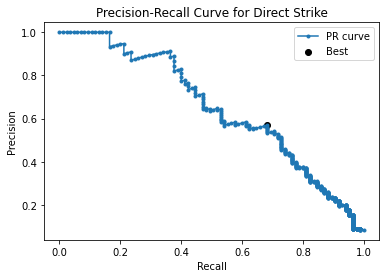

In [29]:
# preliminary testing: can obtain probabilities?
test_obtaining_probabilities(random_forest_tc_clf, dev_X, dev_Y)

# find the best decision thresholds and the corresponding F1 scores
best_thresholds, best_f1_scores = optimize_thresholds(random_forest_tc_clf, dev_X, dev_Y)

# bookkeeping
low_impact_threshold["random_forest_400"] = best_thresholds[0]
mid_impact_threshold["random_forest_400"] = best_thresholds[1]
big_impact_threshold["random_forest_400"] = best_thresholds[2]
direct_strike_threshold["random_forest_400"] = best_thresholds[3]
low_impact_f1["random_forest_400"] = best_f1_scores[0]
mid_impact_f1["random_forest_400"] = best_f1_scores[1]
big_impact_f1["random_forest_400"] = best_f1_scores[2]
direct_strike_f1["random_forest_400"] = best_f1_scores[3]

In [30]:
# train set behaviour
preds = predictions_with_thresholds(random_forest_tc_clf, best_thresholds, train_X)
print("Accuracy on training data: {0:.10f}".format(accuracy_score(train_Y, preds)))

# test model on dev set
preds = predictions_with_thresholds(random_forest_tc_clf, best_thresholds, dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))
base_accuracies["random_forest_400"] = acc
# classification report
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    1.7s finished


Accuracy on training data: 0.9956931800


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s


Accuracy of classifier on dev set: 0.9141525632
              precision    recall  f1-score   support

           0    0.73858   0.77394   0.75584       376
           1    0.75168   0.74916   0.75042       299
           2    0.65161   0.77692   0.70877       130
           3    0.56436   0.67059   0.61290        85

   micro avg    0.70992   0.75618   0.73232       890
   macro avg    0.67656   0.74265   0.70698       890
weighted avg    0.71364   0.75618   0.73349       890
 samples avg    0.08160   0.08638   0.08119       890



[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.7s finished


In [31]:
# F1 score comparison (to dummies)
test_F1_scores(random_forest_tc_clf, best_thresholds, dev_X, dev_Y)

# compute recall, precision and class-based accuracy scores
# low_impact_acc, mid_impact_acc, big_impact_acc, direct_strike_acc = test_usefulness(tc_clf, "dev")
preds = predictions_with_thresholds(random_forest_tc_clf, best_thresholds, dev_X)
recall = recall_score(dev_Y, preds, average=None, zero_division=0)
print("Recall score: ", recall)
low_impact_recall["random_forest_400"] = recall[0]
mid_impact_recall["random_forest_400"] = recall[1]
big_impact_recall["random_forest_400"] = recall[2]
direct_strike_recall["random_forest_400"] = recall[3]

precision = precision_score(dev_Y, preds, average=None, zero_division=0)
print("Precision score: ", precision)
low_impact_precision["random_forest_400"] = precision[0]
mid_impact_precision["random_forest_400"] = precision[1]
big_impact_precision["random_forest_400"] = precision[2]
direct_strike_precision["random_forest_400"] = precision[3]

low_impact_acc, mid_impact_acc, big_impact_acc, direct_strike_acc = test_acc_by_class(random_forest_tc_clf, best_thresholds, dev_X, dev_Y)
low_impact_accuracies["random_forest_400"] = low_impact_acc
mid_impact_accuracies["random_forest_400"] = mid_impact_acc
big_impact_accuracies["random_forest_400"] = big_impact_acc
direct_strike_accuracies["random_forest_400"] = direct_strike_acc

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s


model's F1 score is:  [0.75584416 0.75041876 0.70877193 0.61290323]
dummy (always say Yes) F1 score is:  [0.16887492 0.13665448 0.06180176 0.04084575]
dummy (always say No) F1 score is:  [0. 0. 0. 0.]


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s


Recall score:  [0.77393617 0.74916388 0.77692308 0.67058824]
Precision score:  [0.73857868 0.75167785 0.6516129  0.56435644]


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s


[Class based general acc] now testing: LOW_IMPACT
model's F1 score is:  [0.75584416 0.75250836 0.70877193 0.61290323]
model's accuracy is:  0.953887662496934
[Class based general acc] now testing: MID_IMPACT
model's F1 score is:  [0.75584416 0.75250836 0.70877193 0.61290323]
model's accuracy is:  0.9636987981358842
[Class based general acc] now testing: BIG_IMPACT
model's F1 score is:  [0.75584416 0.75250836 0.70877193 0.61290323]
model's accuracy is:  0.9796418935491783
[Class based general acc] now testing: DIRECT_STRIKE
model's F1 score is:  [0.75584416 0.75250836 0.70877193 0.61290323]
model's accuracy is:  0.9823399558498896


[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.7s finished


In [ ]:
# save model
save_sklearn_model_to_file(random_forest_tc_clf, "random_forest_400")

#### Ensemble: Gradient Boosting Classifier
This one takes a while to train.

(n_estimators=400, max_depth=7) => 91.74% dev acc, F1 \[0.73023635 0.67963153 0.54304636 0.53588517\], 38.62% DS true positive acc, 98.4675% DS general acc; **optimized**: Best Thresholds=\[0.40279 0.30401 0.09552 0.07190\], F-Score=\[0.76547 0.71902 0.66667 0.61333\]

(n_estimators=500, max_depth=7) => 91.87% dev acc, F1 \[0.72622002 0.6846071  0.56666667 0.52688172\], 37.98% DS true positive acc, 98.4286% DS general acc

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.028738
Class 1, no calibration: 0.025449
Class 2, no calibration: 0.016553
Class 3, no calibration: 0.012309


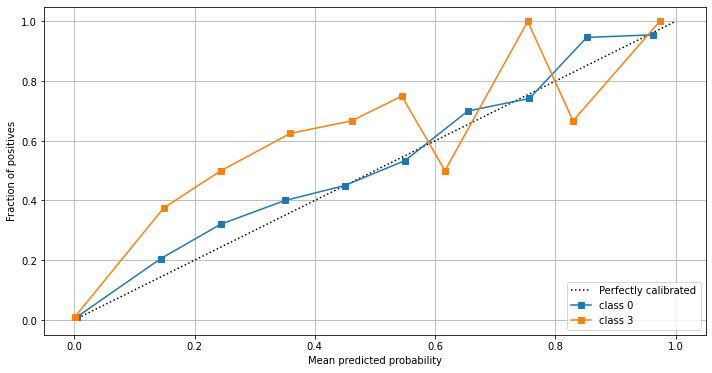

In [32]:
# fit yet another model
sklgb_tc_clf = OneVsRestClassifier(ensemble.GradientBoostingClassifier(
    n_estimators=400, 
    max_depth=7,
    verbose=1
), n_jobs=4)
sklgb_tc_clf.fit(train_X, train_Y)

calibration_plot(sklgb_tc_clf, dev_X, dev_Y)

Testing data item 3410, probabilities: 
[[1.66827644e-05 2.36241791e-05 8.94227009e-08 5.11478811e-07]]
Ground truth:  [0 0 0 0]
Testing data item 1117, probabilities: 
[[2.19480390e-04 1.91551402e-04 2.03752332e-05 9.83049963e-06]]
Ground truth:  [0 0 0 0]
Testing data item 3181, probabilities: 
[[4.19945792e-02 2.51314750e-04 1.77326770e-06 1.91431772e-06]]
Ground truth:  [0 0 0 0]
Testing data item 75, probabilities: 
[[4.69567860e-03 5.36705916e-03 9.25847395e-06 4.46818293e-05]]
Ground truth:  [0 0 0 0]
Testing data item 3405, probabilities: 
[[6.52629821e-01 1.16315950e-03 4.04733343e-04 2.21212300e-04]]
Ground truth:  [1 0 0 0]


/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier wa

Best Threshold=0.36822, F-Score=0.78356
Best Threshold=0.34517, F-Score=0.77972
Best Threshold=0.13313, F-Score=0.71311
Best Threshold=0.07787, F-Score=0.63855


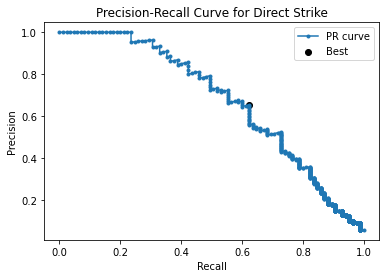

In [33]:
# preliminary testing: can obtain probabilities?
test_obtaining_probabilities(sklgb_tc_clf, dev_X, dev_Y)

# find the best decision thresholds and the corresponding F1 scores
best_thresholds, best_f1_scores = optimize_thresholds(sklgb_tc_clf, dev_X, dev_Y)

# bookkeeping
low_impact_threshold["gradient_boost_400"] = best_thresholds[0]
mid_impact_threshold["gradient_boost_400"] = best_thresholds[1]
big_impact_threshold["gradient_boost_400"] = best_thresholds[2]
direct_strike_threshold["gradient_boost_400"] = best_thresholds[3]
low_impact_f1["gradient_boost_400"] = best_f1_scores[0]
mid_impact_f1["gradient_boost_400"] = best_f1_scores[1]
big_impact_f1["gradient_boost_400"] = best_f1_scores[2]
direct_strike_f1["gradient_boost_400"] = best_f1_scores[3]

In [34]:
# train set behaviour
preds = predictions_with_thresholds(sklgb_tc_clf, best_thresholds, train_X)
print("Accuracy on training data: {0:.10f}".format(accuracy_score(train_Y, preds)))

# test model on dev set
preds = predictions_with_thresholds(sklgb_tc_clf, best_thresholds, dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))
base_accuracies["gradient_boost_400"] = acc
# classification report
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

Accuracy on training data: 0.9999454833
Accuracy of classifier on dev set: 0.9227373068
              precision    recall  f1-score   support

           0    0.80737   0.75798   0.78189       376
           1    0.81618   0.74247   0.77758       299
           2    0.76106   0.66154   0.70782       130
           3    0.65000   0.61176   0.63030        85

   micro avg    0.78851   0.72472   0.75527       890
   macro avg    0.75865   0.69344   0.72440       890
weighted avg    0.78853   0.72472   0.75515       890
 samples avg    0.08450   0.08317   0.08148       890



In [35]:
# F1 score comparison (to dummies)
test_F1_scores(sklgb_tc_clf, best_thresholds, dev_X, dev_Y)

# compute recall, precision and class-based accuracy scores
# low_impact_acc, mid_impact_acc, big_impact_acc, direct_strike_acc = test_usefulness(tc_clf, "dev")
preds = predictions_with_thresholds(sklgb_tc_clf, best_thresholds, dev_X)
recall = recall_score(dev_Y, preds, average=None, zero_division=0)
print("Recall score: ", recall)
low_impact_recall["gradient_boost_400"] = recall[0]
mid_impact_recall["gradient_boost_400"] = recall[1]
big_impact_recall["gradient_boost_400"] = recall[2]
direct_strike_recall["gradient_boost_400"] = recall[3]

precision = precision_score(dev_Y, preds, average=None, zero_division=0)
print("Precision score: ", precision)
low_impact_precision["gradient_boost_400"] = precision[0]
mid_impact_precision["gradient_boost_400"] = precision[1]
big_impact_precision["gradient_boost_400"] = precision[2]
direct_strike_precision["gradient_boost_400"] = precision[3]

low_impact_acc, mid_impact_acc, big_impact_acc, direct_strike_acc = test_acc_by_class(sklgb_tc_clf, best_thresholds, dev_X, dev_Y)
low_impact_accuracies["gradient_boost_400"] = low_impact_acc
mid_impact_accuracies["gradient_boost_400"] = mid_impact_acc
big_impact_accuracies["gradient_boost_400"] = big_impact_acc
direct_strike_accuracies["gradient_boost_400"] = direct_strike_acc

model's F1 score is:  [0.781893   0.77758319 0.70781893 0.63030303]
dummy (always say Yes) F1 score is:  [0.16887492 0.13665448 0.06180176 0.04084575]
dummy (always say No) F1 score is:  [0. 0. 0. 0.]
Recall score:  [0.75797872 0.74247492 0.66153846 0.61176471]
Precision score:  [0.80736544 0.81617647 0.76106195 0.65      ]
[Class based general acc] now testing: LOW_IMPACT
model's F1 score is:  [0.781893   0.77758319 0.70781893 0.63030303]
model's accuracy is:  0.9610007358351729
[Class based general acc] now testing: MID_IMPACT
model's F1 score is:  [0.781893   0.77758319 0.70781893 0.63030303]
model's accuracy is:  0.9688496443463331
[Class based general acc] now testing: BIG_IMPACT
model's F1 score is:  [0.781893   0.77758319 0.70781893 0.63030303]
model's accuracy is:  0.9825852342408634
[Class based general acc] now testing: DIRECT_STRIKE
model's F1 score is:  [0.781893   0.77758319 0.70781893 0.63030303]
model's accuracy is:  0.9850380181506009


In [ ]:
# save model
save_sklearn_model_to_file(sklgb_tc_clf, "gradient_boost_400")

#### New Antic: AdaBoost Classifier
Probably will work decently thanks to its rationale (make another classifier learn from the wrong samples), but the hyperparameter optimization will likely be troublesome. The Brier scores improve slowly and many NaN precision/recall/f1's emerged during the trial-and-error testings. Here are some functional configurations:

400 estimators, LR 0.001: F1-scores \[0.36795, 0.35630, 0.14416, 0.10853\]

500 estimators, LR 0.01: F1-scores \[0.57919 0.52893 0.36930 0.30943\] // seems 0.01 is a good LR

650 estimators, LR 0.01: F1-scores \[0.57793 0.53521 0.36567 0.32231\]

800 estimators (because why not), LR 0.01: F1-scores \[0.57883 0.53211 0.38710 0.30857 \] // are we going to overfit soon?

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.219844
Class 1, no calibration: 0.211330
Class 2, no calibration: 0.195856
Class 3, no calibration: 0.199029


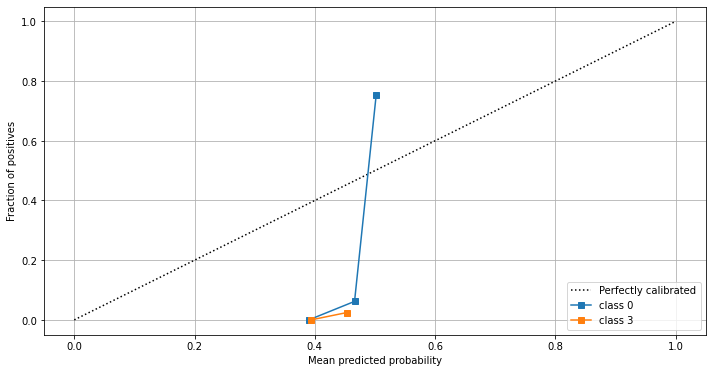

In [46]:
# fit yet another model
adaboost_tc_clf = OneVsRestClassifier(ensemble.AdaBoostClassifier(
    n_estimators=3000, 
    learning_rate=0.02
), n_jobs=-1)
adaboost_tc_clf.fit(train_X, train_Y)

calibration_plot(adaboost_tc_clf, dev_X, dev_Y)

Best Threshold=0.49735, F-Score=0.62368
Best Threshold=0.49595, F-Score=0.60172
Best Threshold=0.49412, F-Score=0.51020
Best Threshold=0.49286, F-Score=0.33929


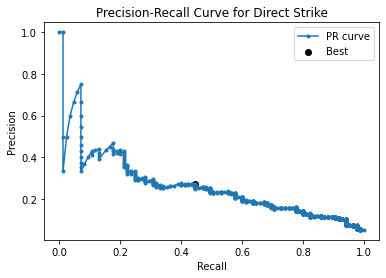

In [48]:
# find the best decision thresholds and the corresponding F1 scores
best_thresholds, best_f1_scores = optimize_thresholds(adaboost_tc_clf, dev_X, dev_Y)

# bookkeeping
low_impact_threshold["adaboost_2000"] = best_thresholds[0]
mid_impact_threshold["adaboost_2000"] = best_thresholds[1]
big_impact_threshold["adaboost_2000"] = best_thresholds[2]
direct_strike_threshold["adaboost_2000"] = best_thresholds[3]
low_impact_f1["adaboost_2000"] = best_f1_scores[0]
mid_impact_f1["adaboost_2000"] = best_f1_scores[1]
big_impact_f1["adaboost_2000"] = best_f1_scores[2]
direct_strike_f1["adaboost_2000"] = best_f1_scores[3]

In [49]:
# train set behaviour
preds = predictions_with_thresholds(adaboost_tc_clf, best_thresholds, train_X)
print("Accuracy on training data: {0:.10f}".format(accuracy_score(train_Y, preds)))

# test model on dev set
preds = predictions_with_thresholds(adaboost_tc_clf, best_thresholds, dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))
base_accuracies["adaboost_2000"] = acc
# classification report
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

Accuracy on training data: 0.8653437279
Accuracy of classifier on dev set: 0.8665685553
              precision    recall  f1-score   support

           0    0.61619   0.62766   0.62187       376
           1    0.52513   0.69900   0.59971       299
           2    0.45399   0.56923   0.50512       130
           3    0.26812   0.43529   0.33184        85

   micro avg    0.51386   0.62472   0.56389       890
   macro avg    0.46585   0.58280   0.51464       890
weighted avg    0.52866   0.62472   0.56967       890
 samples avg    0.06067   0.06966   0.06037       890



In [50]:
# F1 score comparison (to dummies)
test_F1_scores(adaboost_tc_clf, best_thresholds, dev_X, dev_Y)

# compute recall, precision and class-based accuracy scores
# low_impact_acc, mid_impact_acc, big_impact_acc, direct_strike_acc = test_usefulness(tc_clf, "dev")
preds = predictions_with_thresholds(adaboost_tc_clf, best_thresholds, dev_X)
recall = recall_score(dev_Y, preds, average=None, zero_division=0)
print("Recall score: ", recall)
low_impact_recall["adaboost_2000"] = recall[0]
mid_impact_recall["adaboost_2000"] = recall[1]
big_impact_recall["adaboost_2000"] = recall[2]
direct_strike_recall["adaboost_2000"] = recall[3]

precision = precision_score(dev_Y, preds, average=None, zero_division=0)
print("Precision score: ", precision)
low_impact_precision["adaboost_2000"] = precision[0]
mid_impact_precision["adaboost_2000"] = precision[1]
big_impact_precision["adaboost_2000"] = precision[2]
direct_strike_precision["adaboost_2000"] = precision[3]

low_impact_acc, mid_impact_acc, big_impact_acc, direct_strike_acc = test_acc_by_class(adaboost_tc_clf, best_thresholds, dev_X, dev_Y)
low_impact_accuracies["adaboost_2000"] = low_impact_acc
mid_impact_accuracies["adaboost_2000"] = mid_impact_acc
big_impact_accuracies["adaboost_2000"] = big_impact_acc
direct_strike_accuracies["adaboost_2000"] = direct_strike_acc

model's F1 score is:  [0.62187088 0.59971306 0.50511945 0.33183857]
dummy (always say Yes) F1 score is:  [0.16887492 0.13665448 0.06180176 0.04084575]
dummy (always say No) F1 score is:  [0. 0. 0. 0.]
Recall score:  [0.62765957 0.69899666 0.56923077 0.43529412]
Precision score:  [0.61618799 0.52512563 0.45398773 0.26811594]
[Class based general acc] now testing: LOW_IMPACT
model's F1 score is:  [0.62187088 0.59971306 0.50511945 0.33183857]
model's accuracy is:  0.9296051017905322
[Class based general acc] now testing: MID_IMPACT
model's F1 score is:  [0.62187088 0.59971306 0.50511945 0.33183857]
model's accuracy is:  0.9315673289183223
[Class based general acc] now testing: BIG_IMPACT
model's F1 score is:  [0.62187088 0.59971306 0.50511945 0.33183857]
model's accuracy is:  0.9644346333088055
[Class based general acc] now testing: DIRECT_STRIKE
model's F1 score is:  [0.62187088 0.59971306 0.50511945 0.33183857]
model's accuracy is:  0.9634535197449104


### XGBoost Classifiers

#### Generic XGBoost Classifier, OneVsRest
note that training on the GPU was somewhat time consuming.

defaults => 91.27% dev acc, F1 \[0.7086743  0.66737064 0.61728395 0.54822335\], 41.86% DS true positive acc

(n_estimators=400, max_depth=7, tree_method='hist') => 92.34% dev acc, F1 \[0.7496038  0.73084886 0.70833333 0.57943925\], 48.06% DS true positive acc

(n_estimators=400, max_depth=20, tree_method='hist') => 93.05% dev acc, F1 \[0.77378098 0.76386037 0.69512195 0.63302752\], 53.49% DS true positive acc, 98.6103% DS general acc

(n_estimators=500, max_depth=25, tree_method='gpu_hist') => 92.91% dev acc, F1 \[0.78122514 0.74327122 0.6918239  0.647343  \], 51.94% DS true positive acc; **optimized**: Best Thresholds=\[0.21372 0.16961 0.26258 0.40064\], F-Score\[0.80632 0.77365 0.73430 076800\]

(n_estimators=500, max_depth=25, tree_method='hist') => 92.74% dev acc, F1 \[0.7766537  0.73511294 0.68656716 0.49565217\], 36.31% DS true positive acc, 98.4935% DS general acc

/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:41:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:41:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:41:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:41:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Brier score losses: (the smaller the better)
Class 0, no calibration: 0.023525
Class 1, no calibration: 0.019944
Class 2, no calibration: 0.012962
Class 3, no calibration: 0.010623


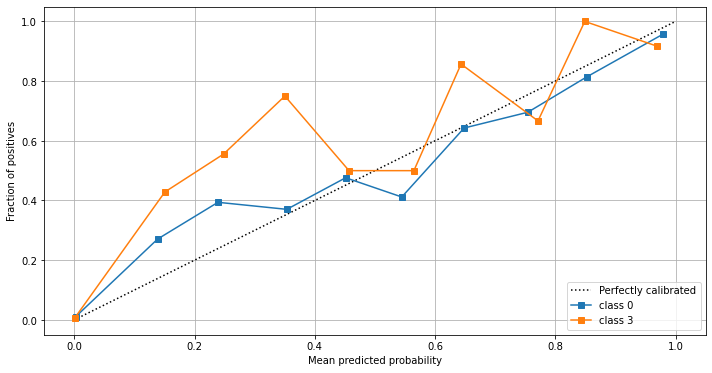

In [51]:
# fit yet another model
ovr_xgb_model = OneVsRestClassifier(xgb.XGBClassifier(
    n_estimators=400, max_depth=25, tree_method='gpu_hist', n_jobs=-1
), n_jobs=-1)
ovr_xgb_model.fit(train_X, train_Y)

calibration_plot(ovr_xgb_model, dev_X, dev_Y)

Testing data item 37, probabilities: 
[[1.90258096e-03 1.30425415e-05 1.57731927e-06 4.18040008e-06]]
Ground truth:  [0 0 0 0]
Testing data item 2940, probabilities: 
[[9.5061478e-06 7.8649447e-07 1.7727022e-07 2.7444312e-06]]
Ground truth:  [0 0 0 0]
Testing data item 1338, probabilities: 
[[1.687855e-06 1.636988e-07 6.638809e-08 2.385775e-07]]
Ground truth:  [0 0 0 0]
Testing data item 1972, probabilities: 
[[5.8136732e-07 3.6581824e-07 1.4379157e-07 3.4502457e-06]]
Ground truth:  [0 0 0 0]
Testing data item 2680, probabilities: 
[[2.8481730e-04 7.4564334e-05 4.2598645e-04 2.0838834e-04]]
Ground truth:  [0 0 0 0]
Best Threshold=0.38818, F-Score=0.82768
Best Threshold=0.17802, F-Score=0.83788
Best Threshold=0.15485, F-Score=0.78599
Best Threshold=0.10892, F-Score=0.69880


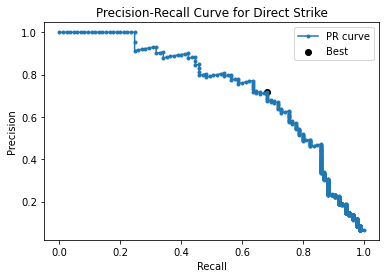

In [52]:
# preliminary testing: can obtain probabilities?
test_obtaining_probabilities(ovr_xgb_model, dev_X, dev_Y)

# find the best decision thresholds and the corresponding F1 scores
best_thresholds, best_f1_scores = optimize_thresholds(ovr_xgb_model, dev_X, dev_Y)

# bookkeeping
low_impact_threshold["xgboost_classifier_400"] = best_thresholds[0]
mid_impact_threshold["xgboost_classifier_400"] = best_thresholds[1]
big_impact_threshold["xgboost_classifier_400"] = best_thresholds[2]
direct_strike_threshold["xgboost_classifier_400"] = best_thresholds[3]
low_impact_f1["xgboost_classifier_400"] = best_f1_scores[0]
mid_impact_f1["xgboost_classifier_400"] = best_f1_scores[1]
big_impact_f1["xgboost_classifier_400"] = best_f1_scores[2]
direct_strike_f1["xgboost_classifier_400"] = best_f1_scores[3]

In [53]:
# train set behaviour
preds = predictions_with_thresholds(ovr_xgb_model, best_thresholds, train_X)
print("Accuracy on training data: {0:.10f}".format(accuracy_score(train_Y, preds)))

# test model on dev set
preds = predictions_with_thresholds(ovr_xgb_model, best_thresholds, dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))
base_accuracies["xgboost_classifier_400"] = acc
# classification report
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

Accuracy on training data: 1.0000000000
Accuracy of classifier on dev set: 0.9367181751
              precision    recall  f1-score   support

           0    0.84444   0.80851   0.82609       376
           1    0.80495   0.86957   0.83601       299
           2    0.79365   0.76923   0.78125       130
           3    0.71250   0.67059   0.69091        85

   micro avg    0.81102   0.81011   0.81057       890
   macro avg    0.78889   0.77947   0.78356       890
weighted avg    0.81116   0.81011   0.80996       890
 samples avg    0.09255   0.09384   0.09119       890



In [54]:
# F1 score comparison (to dummies)
test_F1_scores(ovr_xgb_model, best_thresholds, dev_X, dev_Y)

# compute recall, precision and class-based accuracy scores
# low_impact_acc, mid_impact_acc, big_impact_acc, direct_strike_acc = test_usefulness(tc_clf, "dev")
preds = predictions_with_thresholds(ovr_xgb_model, best_thresholds, dev_X)
recall = recall_score(dev_Y, preds, average=None, zero_division=0)
print("Recall score: ", recall)
low_impact_recall["xgboost_classifier_400"] = recall[0]
mid_impact_recall["xgboost_classifier_400"] = recall[1]
big_impact_recall["xgboost_classifier_400"] = recall[2]
direct_strike_recall["xgboost_classifier_400"] = recall[3]

precision = precision_score(dev_Y, preds, average=None, zero_division=0)
print("Precision score: ", precision)
low_impact_precision["xgboost_classifier_400"] = precision[0]
mid_impact_precision["xgboost_classifier_400"] = precision[1]
big_impact_precision["xgboost_classifier_400"] = precision[2]
direct_strike_precision["xgboost_classifier_400"] = precision[3]

low_impact_acc, mid_impact_acc, big_impact_acc, direct_strike_acc = test_acc_by_class(ovr_xgb_model, best_thresholds, dev_X, dev_Y)
low_impact_accuracies["xgboost_classifier_400"] = low_impact_acc
mid_impact_accuracies["xgboost_classifier_400"] = mid_impact_acc
big_impact_accuracies["xgboost_classifier_400"] = big_impact_acc
direct_strike_accuracies["xgboost_classifier_400"] = direct_strike_acc

model's F1 score is:  [0.82608696 0.83601286 0.78125    0.69090909]
dummy (always say Yes) F1 score is:  [0.16887492 0.13665448 0.06180176 0.04084575]
dummy (always say No) F1 score is:  [0. 0. 0. 0.]
Recall score:  [0.80851064 0.86956522 0.76923077 0.67058824]
Precision score:  [0.84444444 0.80495356 0.79365079 0.7125    ]
[Class based general acc] now testing: LOW_IMPACT
model's F1 score is:  [0.82608696 0.83601286 0.78125    0.69090909]
model's accuracy is:  0.9686043659553594
[Class based general acc] now testing: MID_IMPACT
model's F1 score is:  [0.82608696 0.83601286 0.78125    0.69090909]
model's accuracy is:  0.9749816041206769
[Class based general acc] now testing: BIG_IMPACT
model's F1 score is:  [0.82608696 0.83601286 0.78125    0.69090909]
model's accuracy is:  0.9862644101054697
[Class based general acc] now testing: DIRECT_STRIKE
model's F1 score is:  [0.82608696 0.83601286 0.78125    0.69090909]
model's accuracy is:  0.9874908020603385


In [94]:
# save model
save_sklearn_model_to_file(ovr_xgb_model, "xgboost_classifier_400")

#### XGBRF Classifier: Random Forest version

(n_estimators=400, max_depth=20, tree_method='hist') => 91.40% dev acc, F1 \[0.16141356 0.12629274 0.0471722  0.0329544 \], 32.56% DS true positive acc, 98.2727% DS general acc; **optimized**: Best Thresholds\[0.40434 0.30217 0.30386 0.28034\], F-Score=\[0.75168 0.70534 0.68142 0.56164\]

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.045099
Class 1, no calibration: 0.040223
Class 2, no calibration: 0.028501
Class 3, no calibration: 0.025350


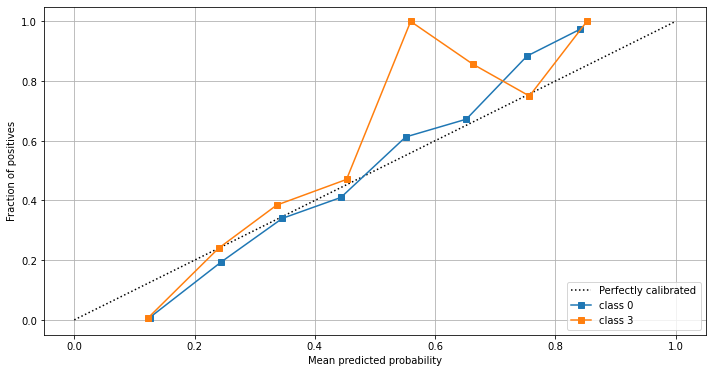

In [55]:
ovr_xgbrf_model = OneVsRestClassifier(xgb.XGBRFClassifier(
    n_estimators=400, max_depth=20, tree_method='gpu_hist', n_jobs=-1
), n_jobs=-1)
ovr_xgbrf_model.fit(train_X, train_Y)

calibration_plot(ovr_xgbrf_model, dev_X, dev_Y)

Testing data item 3160, probabilities: 
[[0.4634631  0.28079554 0.11946585 0.12390468]]
Ground truth:  [0 0 0 0]
Testing data item 1635, probabilities: 
[[0.11999281 0.1192031  0.1192031  0.1192031 ]]
Ground truth:  [0 0 0 0]
Testing data item 1661, probabilities: 
[[0.1503673  0.17176473 0.11946585 0.14331996]]
Ground truth:  [0 0 0 0]
Testing data item 423, probabilities: 
[[0.1192031 0.1192031 0.1192031 0.1192031]]
Ground truth:  [0 0 0 0]
Testing data item 800, probabilities: 
[[0.12210041 0.12435379 0.1192031  0.1192031 ]]
Ground truth:  [0 0 0 0]
Best Threshold=0.35829, F-Score=0.74842
Best Threshold=0.32220, F-Score=0.74576
Best Threshold=0.26620, F-Score=0.68817
Best Threshold=0.27786, F-Score=0.58182


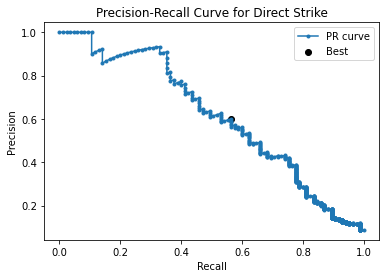

In [56]:
# preliminary testing: can obtain probabilities?
test_obtaining_probabilities(ovr_xgbrf_model, dev_X, dev_Y)

# find the best decision thresholds and the corresponding F1 scores
best_thresholds, best_f1_scores = optimize_thresholds(ovr_xgbrf_model, dev_X, dev_Y)

# bookkeeping
low_impact_threshold["xgboost_forest_400"] = best_thresholds[0]
mid_impact_threshold["xgboost_forest_400"] = best_thresholds[1]
big_impact_threshold["xgboost_forest_400"] = best_thresholds[2]
direct_strike_threshold["xgboost_forest_400"] = best_thresholds[3]
low_impact_f1["xgboost_forest_400"] = best_f1_scores[0]
mid_impact_f1["xgboost_forest_400"] = best_f1_scores[1]
big_impact_f1["xgboost_forest_400"] = best_f1_scores[2]
direct_strike_f1["xgboost_forest_400"] = best_f1_scores[3]

In [57]:
# train set behaviour
preds = predictions_with_thresholds(ovr_xgbrf_model, best_thresholds, train_X)
print("Accuracy on training data: {0:.10f}".format(accuracy_score(train_Y, preds)))

# test model on dev set
preds = predictions_with_thresholds(ovr_xgbrf_model, best_thresholds, dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))
base_accuracies["xgboost_forest_400"] = acc
# classification report
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

Accuracy on training data: 0.9831815952
Accuracy of classifier on dev set: 0.9053225411
              precision    recall  f1-score   support

           0    0.71256   0.78457   0.74684       376
           1    0.69054   0.80602   0.74383       299
           2    0.64189   0.73077   0.68345       130
           3    0.59494   0.55294   0.57317        85

   micro avg    0.68485   0.76180   0.72128       890
   macro avg    0.65998   0.71858   0.68682       890
weighted avg    0.68361   0.76180   0.71998       890
 samples avg    0.08342   0.08826   0.08299       890



In [58]:
# F1 score comparison (to dummies)
test_F1_scores(ovr_xgbrf_model, best_thresholds, dev_X, dev_Y)

# compute recall, precision and class-based accuracy scores
# low_impact_acc, mid_impact_acc, big_impact_acc, direct_strike_acc = test_usefulness(tc_clf, "dev")
preds = predictions_with_thresholds(ovr_xgbrf_model, best_thresholds, dev_X)
recall = recall_score(dev_Y, preds, average=None, zero_division=0)
print("Recall score: ", recall)
low_impact_recall["xgboost_forest_400"] = recall[0]
mid_impact_recall["xgboost_forest_400"] = recall[1]
big_impact_recall["xgboost_forest_400"] = recall[2]
direct_strike_recall["xgboost_forest_400"] = recall[3]

precision = precision_score(dev_Y, preds, average=None, zero_division=0)
print("Precision score: ", precision)
low_impact_precision["xgboost_forest_400"] = precision[0]
mid_impact_precision["xgboost_forest_400"] = precision[1]
big_impact_precision["xgboost_forest_400"] = precision[2]
direct_strike_precision["xgboost_forest_400"] = precision[3]

low_impact_acc, mid_impact_acc, big_impact_acc, direct_strike_acc = test_acc_by_class(ovr_xgbrf_model, best_thresholds, dev_X, dev_Y)
low_impact_accuracies["xgboost_forest_400"] = low_impact_acc
mid_impact_accuracies["xgboost_forest_400"] = mid_impact_acc
big_impact_accuracies["xgboost_forest_400"] = big_impact_acc
direct_strike_accuracies["xgboost_forest_400"] = direct_strike_acc

model's F1 score is:  [0.74683544 0.74382716 0.68345324 0.57317073]
dummy (always say Yes) F1 score is:  [0.16887492 0.13665448 0.06180176 0.04084575]
dummy (always say No) F1 score is:  [0. 0. 0. 0.]
Recall score:  [0.78457447 0.80602007 0.73076923 0.55294118]
Precision score:  [0.71256039 0.69054441 0.64189189 0.59493671]
[Class based general acc] now testing: LOW_IMPACT
model's F1 score is:  [0.74683544 0.74382716 0.68345324 0.57317073]
model's accuracy is:  0.9509443218052489
[Class based general acc] now testing: MID_IMPACT
model's F1 score is:  [0.74683544 0.74382716 0.68345324 0.57317073]
model's accuracy is:  0.9592837870983566
[Class based general acc] now testing: BIG_IMPACT
model's F1 score is:  [0.74683544 0.74382716 0.68345324 0.57317073]
model's accuracy is:  0.9784155015943096
[Class based general acc] now testing: DIRECT_STRIKE
model's F1 score is:  [0.74683544 0.74382716 0.68345324 0.57317073]
model's accuracy is:  0.9828305126318372


In [93]:
# save model
save_sklearn_model_to_file(ovr_xgbrf_model, "xgboost_forest_400")

#### XGB Classifier, Multi-Output  
Different wrapper than before, but identical results.

(n_estimators=400, max_depth=20, tree_method='hist') => 93.05% dev acc, F1 \[[0.77378098 0.76386037 0.69512195 0.63302752\], 53.49% DS true positive acc; **optimized**: Best Thresholds=\[0.23225 0.15819 0.12672 0.16088\], F-Score=\[0.81233 0.79934 0.76147 0.76471\] **best as of 14/12/2021**

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is depre

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.028944
Class 1, no calibration: 0.023761
Class 2, no calibration: 0.008057
Class 3, no calibration: 0.006944


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


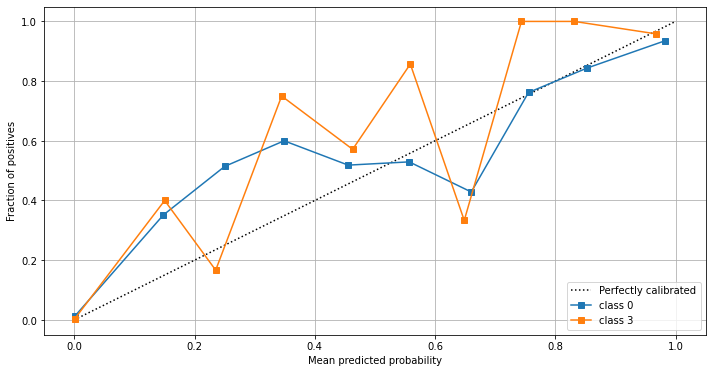

In [31]:
multiout_xgb_model = MultiOutputClassifier(xgb.XGBClassifier(
    n_estimators=400, max_depth=20, tree_method='hist', random_state=42
), n_jobs=-1)
multiout_xgb_model.fit(train_X, train_Y)

calibration_plot(multiout_xgb_model, dev_X, dev_Y)

Testing data item 3562, probabilities: 
[array([[9.999976e-01, 2.390887e-06]], dtype=float32), array([[9.9999785e-01, 2.1682565e-06]], dtype=float32), array([[9.9999923e-01, 7.5687166e-07]], dtype=float32), array([[9.9999952e-01, 4.4910027e-07]], dtype=float32)]
Ground truth:  [0 0 0 0]
Testing data item 1681, probabilities: 
[array([[9.9999988e-01, 1.2548064e-07]], dtype=float32), array([[9.999993e-01, 7.037107e-07]], dtype=float32), array([[9.9999708e-01, 2.9332543e-06]], dtype=float32), array([[9.9999893e-01, 1.0537161e-06]], dtype=float32)]
Ground truth:  [0 0 0 0]
Testing data item 3541, probabilities: 
[array([[9.9999762e-01, 2.3977575e-06]], dtype=float32), array([[9.9999768e-01, 2.3199784e-06]], dtype=float32), array([[9.9999976e-01, 2.4373517e-07]], dtype=float32), array([[9.9999917e-01, 8.1519369e-07]], dtype=float32)]
Ground truth:  [0 0 0 0]
Testing data item 2165, probabilities: 
[array([[9.9943846e-01, 5.6153390e-04]], dtype=float32), array([[9.9970055e-01, 2.9947670e-04]

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


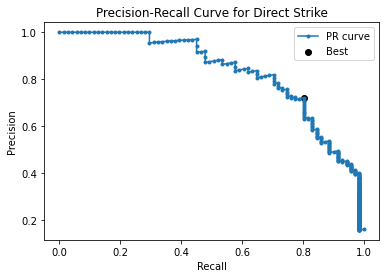

In [32]:
# preliminary testing: can obtain probabilities?
test_obtaining_probabilities(multiout_xgb_model, dev_X, dev_Y)

# find the best decision thresholds and the corresponding F1 scores
best_thresholds, best_f1_scores = optimize_thresholds(multiout_xgb_model, dev_X, dev_Y)

# bookkeeping
low_impact_threshold["xgboost_multioutput_400"] = best_thresholds[0]
mid_impact_threshold["xgboost_multioutput_400"] = best_thresholds[1]
big_impact_threshold["xgboost_multioutput_400"] = best_thresholds[2]
direct_strike_threshold["xgboost_multioutput_400"] = best_thresholds[3]
low_impact_f1["xgboost_multioutput_400"] = best_f1_scores[0]
mid_impact_f1["xgboost_multioutput_400"] = best_f1_scores[1]
big_impact_f1["xgboost_multioutput_400"] = best_f1_scores[2]
direct_strike_f1["xgboost_multioutput_400"] = best_f1_scores[3]

In [33]:
# train set behaviour
preds = predictions_with_thresholds(multiout_xgb_model, best_thresholds, train_X)
print("Accuracy on training data: {0:.10f}".format(accuracy_score(train_Y, preds)))

# test model on dev set
preds = predictions_with_thresholds(multiout_xgb_model, best_thresholds, dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))
base_accuracies["xgboost_multioutput_400"] = acc
# classification report
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Accuracy on training data: 1.0000000000
Accuracy of classifier on dev set: 0.9342653912
              precision    recall  f1-score   support

           0    0.79790   0.81283   0.80530       374
           1    0.74074   0.82707   0.78153       266
           2    0.80899   0.78261   0.79558        92
           3    0.71795   0.78873   0.75168        71

   micro avg    0.77160   0.81196   0.79126       803
   macro avg    0.76639   0.80281   0.78352       803
weighted avg    0.77317   0.81196   0.79157       803
 samples avg    0.08740   0.09086   0.08690       803



/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [34]:
# F1 score comparison (to dummies)
test_F1_scores(multiout_xgb_model, best_thresholds, dev_X, dev_Y)

# compute recall, precision and class-based accuracy scores
# low_impact_acc, mid_impact_acc, big_impact_acc, direct_strike_acc = test_usefulness(tc_clf, "dev")
preds = predictions_with_thresholds(multiout_xgb_model, best_thresholds, dev_X)
recall = recall_score(dev_Y, preds, average=None, zero_division=0)
print("Recall score: ", recall)
low_impact_recall["xgboost_multioutput_400"] = recall[0]
mid_impact_recall["xgboost_multioutput_400"] = recall[1]
big_impact_recall["xgboost_multioutput_400"] = recall[2]
direct_strike_recall["xgboost_multioutput_400"] = recall[3]

precision = precision_score(dev_Y, preds, average=None, zero_division=0)
print("Precision score: ", precision)
low_impact_precision["xgboost_multioutput_400"] = precision[0]
mid_impact_precision["xgboost_multioutput_400"] = precision[1]
big_impact_precision["xgboost_multioutput_400"] = precision[2]
direct_strike_precision["xgboost_multioutput_400"] = precision[3]

low_impact_acc, mid_impact_acc, big_impact_acc, direct_strike_acc = test_acc_by_class(multiout_xgb_model, best_thresholds, dev_X, dev_Y)
low_impact_accuracies["xgboost_multioutput_400"] = low_impact_acc
mid_impact_accuracies["xgboost_multioutput_400"] = mid_impact_acc
big_impact_accuracies["xgboost_multioutput_400"] = big_impact_acc
direct_strike_accuracies["xgboost_multioutput_400"] = direct_strike_acc

model's F1 score is:  [0.80529801 0.78152753 0.79558011 0.75167785]
dummy (always say Yes) F1 score is:  [0.16805212 0.12249597 0.04413528 0.03423337]
dummy (always say No) F1 score is:  [0. 0. 0. 0.]


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Recall score:  [0.81283422 0.82706767 0.7826087  0.78873239]
Precision score:  [0.79790026 0.74074074 0.80898876 0.71794872]
[Class based general acc] now testing: LOW_IMPACT
model's F1 score is:  [0.80529801 0.78152753 0.79558011 0.75167785]
model's accuracy is:  0.963944076526858
[Class based general acc] now testing: MID_IMPACT
model's F1 score is:  [0.80529801 0.78152753 0.79558011 0.75167785]
model's accuracy is:  0.9698307579102281
[Class based general acc] now testing: BIG_IMPACT
model's F1 score is:  [0.80529801 0.78152753 0.79558011 0.75167785]
model's accuracy is:  0.9909246995339711
[Class based general acc] now testing: DIRECT_STRIKE
model's F1 score is:  [0.80529801 0.78152753 0.79558011 0.75167785]
model's accuracy is:  0.9909246995339711


In [92]:
# save model
save_sklearn_model_to_file(multiout_xgb_model, "xgboost_multioutput_400")

#### XGB Classifier, as Classifier chain
The results of the previous classifier is fed into the next one.

(n_estimators=400, max_depth=20, tree_method='gpu_hist', n_jobs=6) => 94.24% dev acc, F1 \[0.82806052 0.78324226 0.77729258 0.72      \], 62.07% DS recall, 98.97% DS base acc; **optimized**: Best Thresholds=\[0.17659 0.27861 0.28913 0.23056\], F-Score=\[0.80884 0.78125 0.76786 0.77698\]

/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:53:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:53:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:53:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:53:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

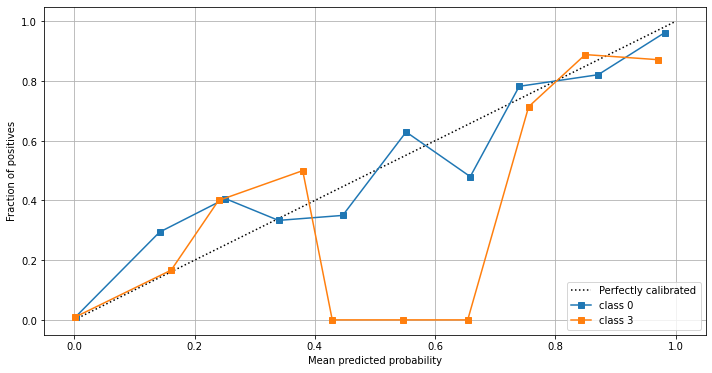

In [63]:
chain_xgb_model = ClassifierChain(xgb.XGBClassifier(
    n_estimators=400, max_depth=20, tree_method='gpu_hist', n_jobs=-1
), order=[0, 1, 2, 3])
chain_xgb_model.fit(train_X, train_Y)

calibration_plot(chain_xgb_model, dev_X, dev_Y)

Testing data item 799, probabilities: 
[[2.19170506e-05 6.48429150e-08 6.86412250e-07 3.77332697e-07]]
Ground truth:  [0 0 0 0]
Testing data item 824, probabilities: 
[[8.09786002e-07 6.75584246e-08 1.99174739e-08 1.10473786e-06]]
Ground truth:  [0 0 0 0]
Testing data item 3496, probabilities: 
[[4.26460929e-07 4.63678447e-07 3.57286496e-07 4.11611268e-07]]
Ground truth:  [0 0 0 0]
Testing data item 2009, probabilities: 
[[1.05491048e-03 9.66038715e-06 2.71503040e-07 8.36280287e-06]]
Ground truth:  [0 0 0 0]
Testing data item 1999, probabilities: 
[[0.99857366 0.99822539 0.99871612 0.04522717]]
Ground truth:  [1 1 1 0]


/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ClassifierChain was fitted with feature names
  warnings.warn(
/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ClassifierChain was fitted with feature names
  warnings.warn(
/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ClassifierChain was fitted with feature names
  warnings.warn(
/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ClassifierChain was fitted with feature names
  warnings.warn(
/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ClassifierChain was fitted with feature names
  warnings.warn(


Best Threshold=0.49538, F-Score=0.83565
Best Threshold=0.48003, F-Score=0.80479
Best Threshold=0.34414, F-Score=0.70588
Best Threshold=0.76562, F-Score=0.67153


/tmp/ipykernel_12078/3998250137.py:14: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


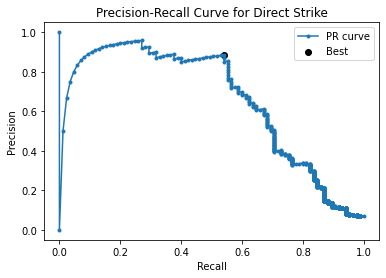

In [64]:
# preliminary testing: can obtain probabilities?
test_obtaining_probabilities(chain_xgb_model, dev_X, dev_Y)

# find the best decision thresholds and the corresponding F1 scores
best_thresholds, best_f1_scores = optimize_thresholds(chain_xgb_model, dev_X, dev_Y)

# bookkeeping
low_impact_threshold["xgboost_chain_400"] = best_thresholds[0]
mid_impact_threshold["xgboost_chain_400"] = best_thresholds[1]
big_impact_threshold["xgboost_chain_400"] = best_thresholds[2]
direct_strike_threshold["xgboost_chain_400"] = best_thresholds[3]
low_impact_f1["xgboost_chain_400"] = best_f1_scores[0]
mid_impact_f1["xgboost_chain_400"] = best_f1_scores[1]
big_impact_f1["xgboost_chain_400"] = best_f1_scores[2]
direct_strike_f1["xgboost_chain_400"] = best_f1_scores[3]

In [65]:
# train set behaviour
preds = predictions_with_thresholds(chain_xgb_model, best_thresholds, train_X)
print("Accuracy on training data: {0:.10f}".format(accuracy_score(train_Y, preds)))

# test model on dev set
preds = predictions_with_thresholds(chain_xgb_model, best_thresholds, dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))
base_accuracies["xgboost_chain_400"] = acc
# classification report
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

Accuracy on training data: 1.0000000000
Accuracy of classifier on dev set: 0.9428501349
              precision    recall  f1-score   support

           0    0.87683   0.79521   0.83403       376
           1    0.82394   0.78261   0.80274       299
           2    0.77570   0.63846   0.70042       130
           3    0.88235   0.52941   0.66176        85

   micro avg    0.84419   0.74270   0.79020       890
   macro avg    0.83971   0.68642   0.74974       890
weighted avg    0.84482   0.74270   0.78755       890
 samples avg    0.08720   0.08642   0.08520       890



In [66]:
# F1 score comparison (to dummies)
test_F1_scores(multiout_xgb_model, best_thresholds, dev_X, dev_Y)

# compute recall, precision and class-based accuracy scores
# low_impact_acc, mid_impact_acc, big_impact_acc, direct_strike_acc = test_usefulness(tc_clf, "dev")
preds = predictions_with_thresholds(chain_xgb_model, best_thresholds, dev_X)
recall = recall_score(dev_Y, preds, average=None, zero_division=0)
print("Recall score: ", recall)
low_impact_recall["xgboost_chain_400"] = recall[0]
mid_impact_recall["xgboost_chain_400"] = recall[1]
big_impact_recall["xgboost_chain_400"] = recall[2]
direct_strike_recall["xgboost_chain_400"] = recall[3]

precision = precision_score(dev_Y, preds, average=None, zero_division=0)
print("Precision score: ", precision)
low_impact_precision["xgboost_chain_400"] = precision[0]
mid_impact_precision["xgboost_chain_400"] = precision[1]
big_impact_precision["xgboost_chain_400"] = precision[2]
direct_strike_precision["xgboost_chain_400"] = precision[3]

low_impact_acc, mid_impact_acc, big_impact_acc, direct_strike_acc = test_acc_by_class(chain_xgb_model, best_thresholds, dev_X, dev_Y)
low_impact_accuracies["xgboost_chain_400"] = low_impact_acc
mid_impact_accuracies["xgboost_chain_400"] = mid_impact_acc
big_impact_accuracies["xgboost_chain_400"] = big_impact_acc
direct_strike_accuracies["xgboost_chain_400"] = direct_strike_acc

model's F1 score is:  [0.82865169 0.8190128  0.72489083 0.51724138]
dummy (always say Yes) F1 score is:  [0.16887492 0.13665448 0.06180176 0.04084575]
dummy (always say No) F1 score is:  [0. 0. 0. 0.]
Recall score:  [0.79521277 0.7826087  0.63846154 0.52941176]
Precision score:  [0.87683284 0.82394366 0.77570093 0.88235294]
[Class based general acc] now testing: LOW_IMPACT
model's F1 score is:  [0.83403068 0.80274443 0.70042194 0.66176471]
model's accuracy is:  0.9708118714741232
[Class based general acc] now testing: MID_IMPACT
model's F1 score is:  [0.83403068 0.80274443 0.70042194 0.66176471]
model's accuracy is:  0.9717929850380181
[Class based general acc] now testing: BIG_IMPACT
model's F1 score is:  [0.83403068 0.80274443 0.70042194 0.66176471]
model's accuracy is:  0.9825852342408634
[Class based general acc] now testing: DIRECT_STRIKE
model's F1 score is:  [0.83403068 0.80274443 0.70042194 0.66176471]
model's accuracy is:  0.9887171940152073


In [91]:
# save model
save_sklearn_model_to_file(chain_xgb_model, "xgboost_chain_400")

##### Reference only: sklearn gradient boosting classifier, but MultiOutputClassifier wrapped
minimal difference observed. Do not wrap this in ClassifierChain instead if you want this to finish as quickly as the others

(n_estimators=400, max_depth=7) => 91.89% dev acc, F1 \[[0.73105745 0.67745415 0.58169935 0.54255319\], 39.53% DS true positive acc

##### Reference only: Regressing first, then compute probabilities

(n_estimators=400, max_depth=20, tree_method='hist') => 91.01% dev acc

In [36]:
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(xgb.XGBRegressor(
    n_estimators=400, max_depth=20, tree_method='hist', random_state=42
), n_jobs=-1)
model.fit(train_X, train_Y)
print("Training accuracy: {0:.10f}".format(model.score(train_X, train_Y)))

probs = model.predict(dev_X)
preds = []
for sample in probs:
    pred_sample = []
    for class_ in sample:
        pred_sample.append(1 if class_ > 0.5 else 0)
    preds.append(pred_sample)
acc = accuracy_score(dev_Y, preds)
print("Accuracies based on probabilities: {0:.10f}".format(acc))

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is depre

Training accuracy: 0.9999825272
Accuracies based on probabilities: 0.9087564386


Best Threshold=0.39453, F-Score=0.73077
Best Threshold=0.46107, F-Score=0.69632
Best Threshold=0.29040, F-Score=0.61261
Best Threshold=0.49177, F-Score=0.61538


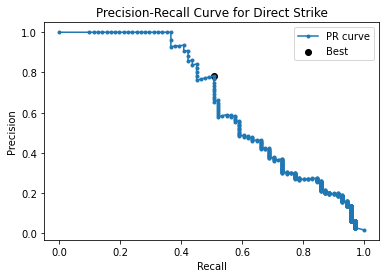

In [37]:
all_preds = np.clip(model.predict(dev_X), 0, 1)

best_thresholds = []
best_f1_scores = []
for i in range(4):
    precision, recall, thresholds = precision_recall_curve(dev_Y[:,i], all_preds[:,i])
    # find best threshold
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.nanargmax(fscore)
    best_thresholds.append(thresholds[ix])
    best_f1_scores.append(fscore[ix])
    print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.', label='PR curve')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Direct Strike')
plt.legend()

In [38]:
preds = []
# iterate each predicted probability and compare against threshold
for i in range(len(all_preds)):
    pred_row = []
    for j in range(4):
        if all_preds[i,j] > best_thresholds[j]:
            pred_row.append(1)
        else:
            pred_row.append(0)
    preds.append(pred_row)

preds = np.array(preds)

In [39]:
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.70123   0.75936   0.72914       374
           1    0.71600   0.67293   0.69380       266
           2    0.51938   0.72826   0.60633        92
           3    0.77778   0.49296   0.60345        71

   micro avg    0.68154   0.70361   0.69240       803
   macro avg    0.67860   0.66338   0.65818       803
weighted avg    0.69206   0.70361   0.69225       803
 samples avg    0.07933   0.07806   0.07594       803



Brier score losses: (the smaller the better)
Class 0, no calibration: 0.037125
Class 1, no calibration: 0.028732
Class 2, no calibration: 0.011937
Class 3, no calibration: 0.009804


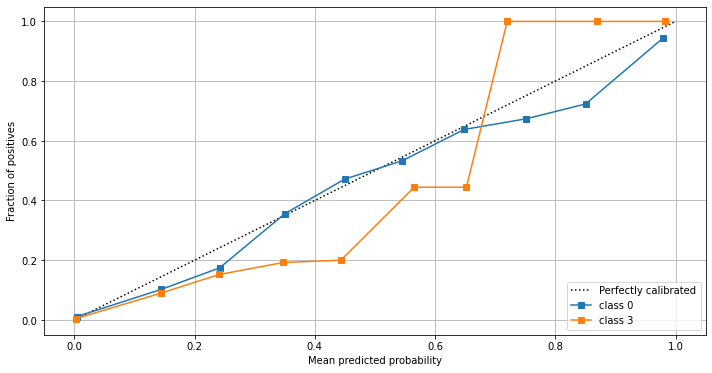

In [40]:
print("Brier score losses: (the smaller the better)")
for i in range(4):
    preds = all_preds[:,i]
    clf_score = brier_score_loss(dev_Y[:,i], preds)
    print("Class {0}, no calibration: {1:1.6f}".format(i, clf_score))

# plot calibration graphs
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
ax = fig.add_subplot(gs[:2, :2])

preds = all_preds
preds = preds[:,0]
display = CalibrationDisplay.from_predictions(dev_Y[:,0], preds, n_bins=10, name="class 0", ax=ax, strategy='uniform')
preds = all_preds
preds = preds[:,3]
display = CalibrationDisplay.from_predictions(dev_Y[:,3], preds, n_bins=10, name="class 3", ax=ax, strategy='uniform')

ax.grid()
plt.tight_layout()
plt.show()

### Visualizations of models' performance

In [76]:
# model selection
import operator

print("Model F1 Recall Precision")
best = max(low_impact_f1.items(), key=operator.itemgetter(1))[0]
print("{0}: {1:05f} {2:05f} {3:05f}".format(best, low_impact_f1[best], low_impact_recall[best], low_impact_precision[best]))
best = max(mid_impact_f1.items(), key=operator.itemgetter(1))[0]
print("{0}: {1:05f} {2:05f} {3:05f}".format(best, mid_impact_f1[best], mid_impact_recall[best], mid_impact_precision[best]))
best = max(big_impact_f1.items(), key=operator.itemgetter(1))[0]
print("{0}: {1:05f} {2:05f} {3:05f}".format(best, big_impact_f1[best], big_impact_recall[best], big_impact_precision[best]))
best = max(direct_strike_f1.items(), key=operator.itemgetter(1))[0]
print("{0}: {1:05f} {2:05f} {3:05f}".format(best, direct_strike_f1[best], direct_strike_recall[best], direct_strike_precision[best]))

Model F1 Recall Precision
xgboost_chain_400: 0.835655 0.795213 0.876833
xgboost_multioutput_400: 0.838926 0.832776 0.841216
xgboost_multioutput_400: 0.802974 0.823077 0.775362
xgboost_multioutput_400: 0.732026 0.647059 0.820896


In [77]:
# convert dictionaries to dataframes
base_acc = pd.DataFrame(base_accuracies, index=[0])
low_impact_acc = pd.DataFrame(low_impact_accuracies, index=[0])
mid_impact_acc = pd.DataFrame(mid_impact_accuracies, index=[0])
big_impact_acc = pd.DataFrame(big_impact_accuracies, index=[0])
ds_acc = pd.DataFrame(direct_strike_accuracies, index=[0])

low_impact_recall = pd.DataFrame(low_impact_recall, index=[0])
mid_impact_recall = pd.DataFrame(mid_impact_recall, index=[0])
big_impact_recall = pd.DataFrame(big_impact_recall, index=[0])
ds_recall = pd.DataFrame(direct_strike_recall, index=[0])

low_impact_precision = pd.DataFrame(low_impact_precision, index=[0])
mid_impact_precision = pd.DataFrame(mid_impact_precision, index=[0])
big_impact_precision = pd.DataFrame(big_impact_precision, index=[0])
ds_precision = pd.DataFrame(direct_strike_precision, index=[0])

low_impact_f1 = pd.DataFrame(low_impact_f1, index=[0])
mid_impact_f1 = pd.DataFrame(mid_impact_f1, index=[0])
big_impact_f1 = pd.DataFrame(big_impact_f1, index=[0])
ds_f1 = pd.DataFrame(direct_strike_f1, index=[0])

In [ ]:
plt.rcParams["figure.autolayout"] = True
base_acc.plot.bar(ylim=(0.85,1))
plt.title("Accuracies overall")
plt.axhline(y=ALWAYS_NO_ACC, linewidth=1, label='naive forecaster')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

In [ ]:
low_impact_acc.plot.bar(ylim=(0.85,1))
plt.title("Accuracies predicting minimal/low impact")
plt.axhline(y=ALWAYS_NO_CLASS_ACC[0], linewidth=1, label='naive forecaster')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

In [ ]:
mid_impact_acc.plot.bar(ylim=(0.85,1))
plt.title("Accuracies predicting limited/mid impact")
plt.axhline(y=ALWAYS_NO_CLASS_ACC[1], linewidth=1, label='naive forecaster')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

In [ ]:
big_impact_acc.plot.bar(ylim=(0.95,1))
plt.title("Accuracies predicting substantial/big impact")
plt.axhline(y=ALWAYS_NO_CLASS_ACC[2], linewidth=1, label='naive forecaster')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

In [ ]:
ds_acc.plot.bar(ylim=(0.95,1))
plt.title("Accuracies predicting direct strikes")
plt.axhline(y=ALWAYS_NO_CLASS_ACC[3], linewidth=1, label='naive forecaster')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

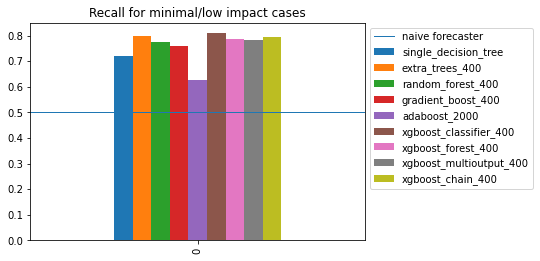

In [78]:
low_impact_recall.plot.bar()
plt.title("Recall for minimal/low impact cases")
plt.axhline(y=0.5, linewidth=1, label='naive forecaster')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

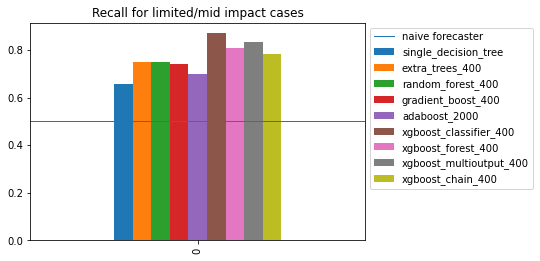

In [79]:
mid_impact_recall.plot.bar()
plt.title("Recall for limited/mid impact cases")
plt.axhline(y=0.5, linewidth=1, label='naive forecaster')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

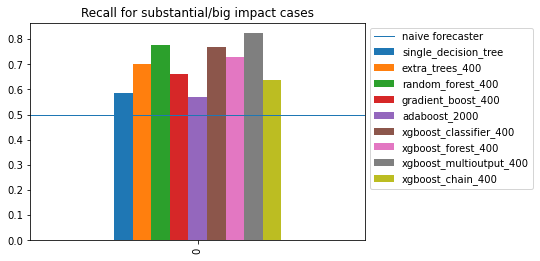

In [80]:
big_impact_recall.plot.bar()
plt.title("Recall for substantial/big impact cases")
plt.axhline(y=0.5, linewidth=1, label='naive forecaster')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

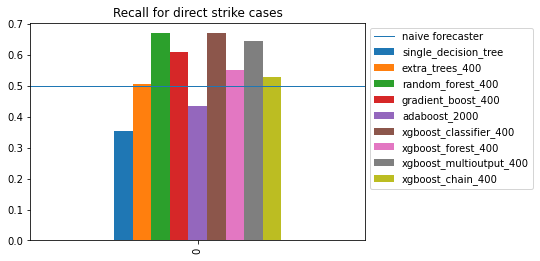

In [81]:
ds_recall.plot.bar()
plt.title("Recall for direct strike cases")
plt.axhline(y=0.5, linewidth=1, label='naive forecaster')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

In [82]:
preds = [[1, 1, 1, 1] for i in range(len(splitDataset["dev"]))]
precision_score(dev_Y, preds, average=None, zero_division=0)

array([0.09222468, 0.07333824, 0.03188619, 0.02084866])

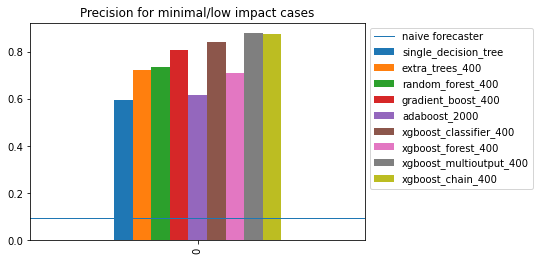

In [83]:
low_impact_precision.plot.bar()
plt.title("Precision for minimal/low impact cases")
plt.axhline(y=0.09565857, linewidth=1, label='naive forecaster')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

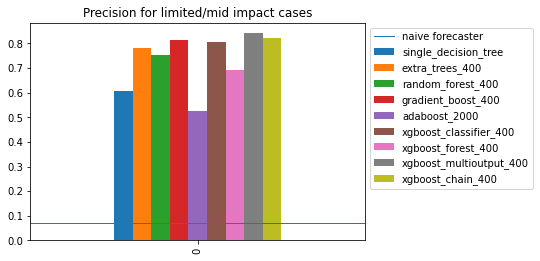

In [84]:
mid_impact_precision.plot.bar()
plt.title("Precision for limited/mid impact cases")
plt.axhline(y=0.07137601, linewidth=1, label='naive forecaster')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

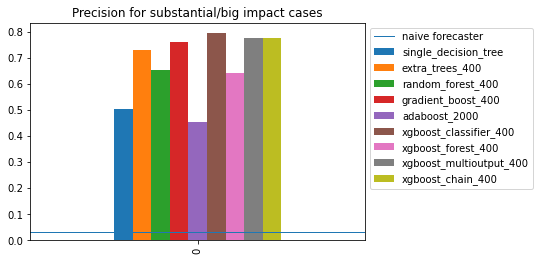

In [85]:
big_impact_precision.plot.bar()
plt.title("Precision for substantial/big impact cases")
plt.axhline(y=0.03041452, linewidth=1, label='naive forecaster')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

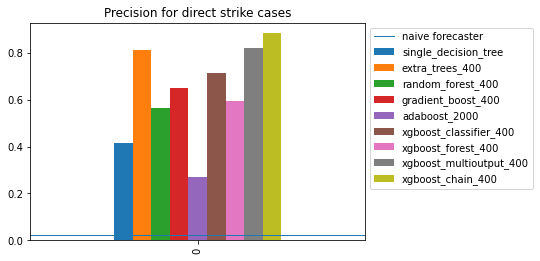

In [86]:
ds_precision.plot.bar()
plt.title("Precision for direct strike cases")
plt.axhline(y=0.02133922, linewidth=1, label='naive forecaster')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

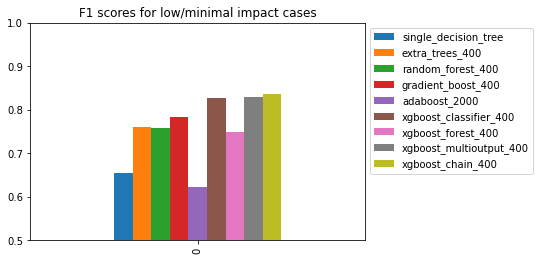

In [87]:
low_impact_f1.plot.bar(ylim=(0.5,1.0))
plt.title("F1 scores for low/minimal impact cases")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

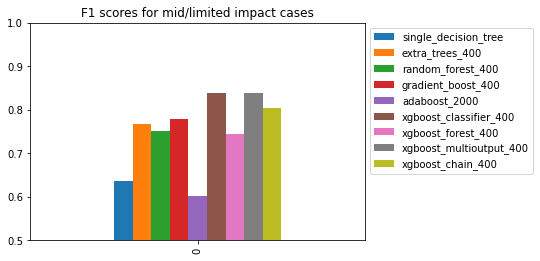

In [88]:
mid_impact_f1.plot.bar(ylim=(0.5,1.0))
plt.title("F1 scores for mid/limited impact cases")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

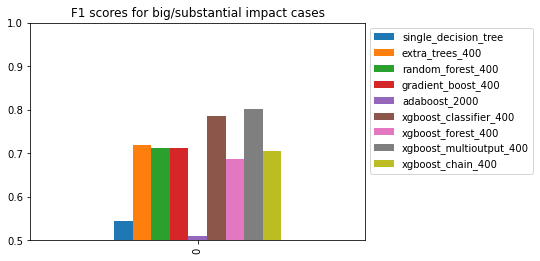

In [89]:
big_impact_f1.plot.bar(ylim=(0.5,1.0))
plt.title("F1 scores for big/substantial impact cases")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

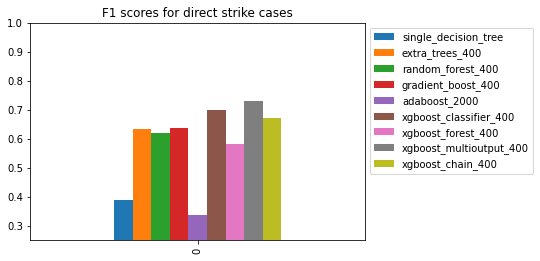

In [90]:
ds_f1.plot.bar(ylim=(0.25,1.0))
plt.title("F1 scores for direct strike cases")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()